## Accurate Product Demand Forecasting for Favorita Stores

1. Business Understanding

### Project Understanding.
**Background.**
Corporation Favorita, a prominent grocery retailer based in Ecuador, aims to ensure optimal stock levels across its various stores to meet customer demand without overstocking. The marketing and sales teams have provided historical sales data to support this objective.

**Goal.**
The primary goal is to develop machine learning models that accurately forecast product demand across different Favorita stores. This will help in maintaining appropriate inventory levels, reducing stockouts and overstock situations, thereby optimizing sales and customer satisfaction.

**Objectives.**
- Predict Unit Sales: Develop a model to predict the unit sales of products at various Favorita stores.
- Analyze Sales Trends: Examine historical sales data to identify trends, patterns, and factors influencing sales.
- Incorporate External Factors: Consider external factors like promotions, oil prices, holidays, and significant events (e.g., earthquakes) in the model.
- Evaluate Store Performance: Compare sales performance across different stores, regions, and product families.
- Optimize Inventory Management: Use the predictions to improve inventory management and supply chain decisions.

**Business Questions and Hypotheses.**
**Business Questions.**
1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.
**Hypotheses**
- Null Hypothesis: Promotions do not have a significant effect on the sales of products.
- Alternative Hypothesis: Promotions have a significant effect on the sales of products.


**Data Description and Sources.**
- train.csv: Historical sales data, including dates, store numbers, product family, on-promotion status, and sales figures.
- test.csv: Test data for predicting sales, with the same features as the training data.
- transaction.csv: Daily transactions per store.
- stores.csv: Metadata for stores, including city, state, type, and cluster.
- oil.csv: Daily oil prices, relevant for the economic context of Ecuador.
- holidays_events.csv: Information on holidays and events, including metadata and transferred dates.
- sample_submission.csv: Sample format for submitting predictions.

## Column description

1. **id**: Unique identifier for each record.
2. **date**: Date of the sales record.
3. **store_nbr**: Unique store number.
4. **family**: Category of the product.
5. **sales**: Number of units sold.
6. **onpromotion**: Number of items on promotion.
7. **year**: Year of the sales record.
8. **month**: Month of the sales record.
9. **week**: Week of the sales record.
10. **day_name**: Day of the week (e.g., Monday, Tuesday).
11. **city**: City where the store is located.
12. **state**: State where the store is located.
13. **type_x**: Type of the store.
14. **cluster**: Cluster/group of the store (similar stores are in the same cluster).
15. **transactions**: Number of transactions recorded in the store on the given date.
16. **dcoilwtico**: Daily oil price in Ecuador.
17. **type_y**: Type of holiday or event.
18. **locale**: Scope of the holiday or event (e.g., national, regional).
19. **locale_name**: Specific location name of the holiday or event.
20. **description**: Description of the holiday or event.
21. **transferred**: Indicator if the holiday or event was transferred to another date.



2. Data understanding

#### Importation of Necessary packages

In [7]:
#Import packages
# Data Handling
import pyodbc
from dotenv import dotenv_values
import numpy as np
import pandas as pd
import seaborn as sns
 
# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
 
# Statistical Analysis
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
 
 
# Feature Processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
 
# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import RandomizedSearchCV
import pickle
 
 
# Other Packages
import warnings
 
warnings.filterwarnings("ignore")

#### Loading the Datasets

Creating a connection by accessing  connection string with the defined environment variables

In [8]:
# Import necessary libraries
from dotenv import dotenv_values
import pyodbc

# Loading environment variables from .env file
environment_variables = dotenv_values('.env')

# Getting the values for the credentials set in the .env file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

# Create a connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"
# Connecting to the server
try:
    connection = pyodbc.connect(connection_string)
    print("Connection successful")
except Exception as e:
    print(f"Connection failed: {e}")


Connection successful


In [9]:
# Define the SQL query to show specific tables in the database
db_query = """
        SELECT *
        FROM INFORMATION_SCHEMA.TABLES
        WHERE TABLE_SCHEMA = 'dbo'
        """
# Read data from the SQL query result into a DataFrame using the established database connection
schema_df = pd.read_sql(db_query, connection)

#  Check whether data has been retrieved successfully to confirm successful connection to database
try:
    schema_df = pd.read_sql(db_query, connection)    
    print("Data retrieved successfully")
    print()
    print(schema_df)    
except Exception as e:
    print("Failed to retrieve data:", e)

Data retrieved successfully

  TABLE_CATALOG TABLE_SCHEMA       TABLE_NAME  TABLE_TYPE
0         dapDB          dbo  holidays_events  BASE TABLE
1         dapDB          dbo              oil  BASE TABLE
2         dapDB          dbo           stores  BASE TABLE


In [10]:
# Define the SQL query to show specific tables in the database
db_query = """
        SELECT *
        FROM stores        
        """
# Read data from the SQL query result into a DataFrame 
df_stores = pd.read_sql(db_query, connection)

# Display the DataFrame
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [11]:
# Define the SQL query to show specific tables in the database
db_query = """
        SELECT *
        FROM oil        
        """
# Read data from the SQL query result into a DataFrame using the established database connection
df_oil = pd.read_sql(db_query, connection)

# Display the DataFrame
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [12]:
# Define the SQL query to show specific tables in the database
db_query = """
        SELECT *
        FROM holidays_events        
        """
# Read data from the SQL query result into a DataFrame
df_holidays = pd.read_sql(db_query, connection)

# Display the DataFrame
df_holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


Loading the othe datasets

In [13]:
#loading train_csv
train_data =pd.read_csv("train.csv")
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [14]:
#loading test dataset
test_data = pd.read_csv("test.csv")
test_data

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [15]:
#loading transaction csv
tn_data = pd.read_csv("transactions.csv")
tn_data

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [16]:
#A look at the submission csv
ss_data = pd.read_csv("sample_submission.csv")
ss_data

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
...,...,...
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0


### EXPLORATORY DATA ANALYSIS

Data Quality Assessment

In [17]:
#gettng to know the data we are dealing with
print("="*50)
print("First Five rows ","\n")
print(df_oil.head(5),"\n")

print("="*50)
print("Information About Dataset","\n")
print(df_oil.info(),"\n")

print("="*50)
print("Describe the Dataset","\n")
print(df_oil.describe().T,"\n")

print("="*50)
print("Null Values t ","\n")
print(df_oil.isnull().sum(),"\n")

print("="*50)
print(" Shape of the Dataset","\n")
print(df_oil.shape,"\n")

First Five rows  

         date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02   93.139999
2  2013-01-03   92.970001
3  2013-01-04   93.120003
4  2013-01-07   93.199997 

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None 

Describe the Dataset 

             count       mean        std        min        25%        50%  \
dcoilwtico  1175.0  67.714366  25.630476  26.190001  46.405001  53.189999   

              75%         max  
dcoilwtico  95.66  110.620003   

Null Values t  

date           0
dcoilwtico    43
dtype: int64 

 Shape of the Dataset 

(1218, 2) 



In [18]:
#gettng to know the data we are dealing with
print("="*50)
print("First Five rows ","\n")
print(df_stores.head(5),"\n")

print("="*50)
print("Information About Dataset","\n")
print(df_stores.info(),"\n")

print("="*50)
print("Describe the Dataset","\n")
print(df_stores.describe().T,"\n")

print("="*50)
print("Null Values t ","\n")
print(df_stores.isnull().sum(),"\n")

print("="*50)
print(" Shape of the Dataset","\n")
print(df_stores.shape,"\n")

First Five rows  

   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4 

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None 

Describe the Dataset 

           count       mean        std  min    25%  

In [19]:
#gettng to know the data we are dealing with
print("="*50)
print("First Five rows ","\n")
print(df_holidays.head(5),"\n")

print("="*50)
print("Information About Dataset","\n")
print(df_holidays.info(),"\n")

print("="*50)
print("Describe the Dataset","\n")
print(df_holidays.describe().T,"\n")

print("="*50)
print("Null Values t ","\n")
print(df_holidays.isnull().sum(),"\n")

print("="*50)
print(" Shape of the Dataset","\n")
print(df_holidays.shape,"\n")

First Five rows  

         date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False   

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 no

In [20]:
#gettng to know the data we are dealing with
print("="*50)
print("First Five rows ","\n")
print(train_data.head(5),"\n")

print("="*50)
print("Information About Dataset","\n")
print(train_data.info(),"\n")

print("="*50)
print("Describe the Dataset","\n")
print(train_data.describe().T,"\n")

print("="*50)
print("Null Values t ","\n")
print(train_data.isnull().sum(),"\n")

print("="*50)
print(" Shape of the Dataset","\n")
print(train_data.shape,"\n")

First Five rows  

   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0 

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None 

Describe the Dataset 

                 count          mean            std  min        25%  \
id           3000888.0  1.500444e+06  866281.891642  0.0  750221.75   
store_nbr    3000888.0  2.750

In [21]:
#gettng to know the data we are dealing with
print("="*50)
print("First Five rows ","\n")
print(tn_data.head(5),"\n")

print("="*50)
print("Information About Dataset","\n")
print(tn_data.info(),"\n")

print("="*50)
print("Describe the Dataset","\n")
print(tn_data.describe().T,"\n")

print("="*50)
print("Null Values t ","\n")
print(tn_data.isnull().sum(),"\n")

print("="*50)
print(" Shape of the Dataset","\n")
print(tn_data.shape,"\n")

First Five rows  

         date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922 

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB
None 

Describe the Dataset 

                count         mean         std  min     25%     50%     75%  \
store_nbr     83488.0    26.939237   15.608204  1.0    13.0    27.0    40.0   
transactions  83488.0  1694.602158  963.286644  5.0  1046.0  1393.0  2079.0   

                 max  
store_nbr       54.0  
transactions  8359.0   

Null Value

In [22]:
#gettng to know the data we are dealing with
print("="*50)
print("First Five rows ","\n")
print(test_data.head(5),"\n")

print("="*50)
print("Information About Dataset","\n")
print(test_data.info(),"\n")

print("="*50)
print("Describe the Dataset","\n")
print(test_data.describe().T,"\n")

print("="*50)
print("Null Values t ","\n")
print(test_data.isnull().sum(),"\n")

print("="*50)
print(" Shape of the Dataset","\n")
print(test_data.shape,"\n")

First Five rows  

        id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0 

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB
None 

Describe the Dataset 

               count          mean          std        min         25%  \
id           28512.0  3.015144e+06  8230.849774 

In [23]:
df_oil.columns

Index(['date', 'dcoilwtico'], dtype='object')

In [24]:
# Fill missing values in the 'dcoilwtico' column using backfill strategy
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='backfill')

**check for duplicates in all datasets**

In [25]:
df_oil.duplicated().sum()

0

In [26]:
df_holidays.duplicated().sum()

0

In [27]:
df_stores.duplicated().sum()

0

In [28]:
test_data.duplicated().sum()

0

In [29]:
train_data.duplicated().sum()

0

In [30]:
tn_data.duplicated().sum()

0

**Insights.**
1. oil dataset has missing values on the 'dcoilwtico' column.
2. The date columns in all dataset is not datetime datatype
3. There are no duplicated rows in the datasets

**changing date columns into datetime datatype**

In [31]:

# Fill missing values in the 'dcoilwtico' column using backfill strategy
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='backfill')
 
# Check for missing values after handling
missing_values_after = df_oil['dcoilwtico'].isnull().sum()
missing_values_after
 

0

#### Transforming date column

In [32]:
# Converting the 'date' column in the datasets to datetime format
# Train dataset
train_data['date'] = pd.to_datetime(train_data['date'])

# Test dataset
test_data['date'] = pd.to_datetime(test_data['date'])

# Holiday Events dataset
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

# Oil dataset
df_oil['date'] = pd.to_datetime(df_oil['date'])

# Transactions dataset
tn_data['date'] = pd.to_datetime(tn_data['date'])

In [33]:
# Confirm the data type of the 'date' column after transformation
print('Date Column Data Type After Transformation:') 
print('==='*14)
print("Train dataset:", train_data['date'].dtype)
print("Test dataset:", test_data['date'].dtype)
print("Holiday Events dataset:", df_holidays['date'].dtype)
print("Oil dataset:", df_oil['date'].dtype)
print("Transactions dataset:", tn_data['date'].dtype)

Date Column Data Type After Transformation:
Train dataset: datetime64[ns]
Test dataset: datetime64[ns]
Holiday Events dataset: datetime64[ns]
Oil dataset: datetime64[ns]
Transactions dataset: datetime64[ns]


In [34]:
# Check the completeness of the train dataset
min_date = train_data['date'].min()
max_date = train_data['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(train_data['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is incomplete. The following dates are missing:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


In [35]:
# Complete the missing dates in the train dataset
# Create an index of the missing dates as a DatetimeIndex object
missing_dates = pd.Index(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]')

# Create a DataFrame with the missing dates, using the 'date' column
missing_data = pd.DataFrame({'date': missing_dates})

# Concatenate the original train dataset and the missing data DataFrame
# ignore_index=True ensures a new index is assigned to the resulting DataFrame
train_data = pd.concat([train_data, missing_data], ignore_index=True)

# Sort the DataFrame based on the 'date' column in ascending order
train_data.sort_values('date', inplace=True)

#### confirming the train data completeness

In [36]:
# Check the completeness of the train dataset
min_date = train_data['date'].min()
max_date = train_data['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(train_data['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is complete. It includes all the required dates.


In [37]:
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1218 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [38]:
# Extract date features
train_data['year'] = train_data['date'].dt.year
train_data['month'] = train_data['date'].dt.month
train_data['day'] = train_data['date'].dt.day
train_data['day_of_week'] = train_data['date'].dt.dayofweek
train_data['week'] = train_data['date'].dt.isocalendar().week
train_data['quarter'] = train_data['date'].dt.quarter

merge the datasets

In [39]:
# Merging the common columns ('store_nbr' and 'date') in the datasets using the inner merge() function
# Merge train_df with stores_df based on 'store_nbr' column
merged_df1 = train_data.merge(df_stores, on='store_nbr', how='inner')
 
# Merge merged_df1 with transactions_df based on 'date' and 'store_nbr' columns
merged_df2 = merged_df1.merge(tn_data, on=['date', 'store_nbr'], how='inner')
 
# Merge merged_df2 with holidays_events_df based on 'date' column
merged_df3 = merged_df2.merge(df_holidays, on='date', how='inner')
 
# Merge merged_df3 with oil_df based on 'date' column
merged_data = merged_df3.merge(df_oil, on='date', how='inner')
 
# View the first five rows of the merged dataset
merged_data.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,...,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,73062.0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73085.0,2013-02-11,1.0,MAGAZINES,0.0,0.0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73084.0,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73083.0,2013-02-11,1.0,LINGERIE,0.0,0.0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73082.0,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [40]:
#overview about the data
merged_data.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,...,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,73062.0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73085.0,2013-02-11,1.0,MAGAZINES,0.0,0.0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73084.0,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73083.0,2013-02-11,1.0,LINGERIE,0.0,0.0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73082.0,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


check for unique values

In [41]:
columns = merged_data.columns
columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year',
       'month', 'day', 'day_of_week', 'week', 'quarter', 'city', 'state',
       'type_x', 'cluster', 'transactions', 'type_y', 'locale', 'locale_name',
       'description', 'transferred', 'dcoilwtico'],
      dtype='object')

In [42]:
#confirm unique values 
for column in columns:
    print(f'{column}')
    print(f'There are {merged_data[column].unique().size} unique values')
    print(f'There are {merged_data[column].unique()}')
    print('='* 50)

id
There are 292545 unique values
There are [  73062.   73085.   73084. ... 1297886. 1297885. 1297884.]
date
There are 179 unique values
There are <DatetimeArray>
['2013-02-11 00:00:00', '2013-02-12 00:00:00', '2013-04-01 00:00:00',
 '2013-04-12 00:00:00', '2013-04-29 00:00:00', '2013-05-01 00:00:00',
 '2013-05-24 00:00:00', '2013-06-25 00:00:00', '2013-07-03 00:00:00',
 '2013-07-23 00:00:00',
 ...
 '2017-06-23 00:00:00', '2017-07-03 00:00:00', '2017-07-24 00:00:00',
 '2017-07-25 00:00:00', '2017-08-10 00:00:00', '2017-08-11 00:00:00',
 '2017-08-15 00:00:00', '2014-01-01 00:00:00', '2013-01-01 00:00:00',
 '2015-01-01 00:00:00']
Length: 179, dtype: datetime64[ns]
store_nbr
There are 54 unique values
There are [ 1. 41. 43. 40.  4. 45. 44. 46. 35. 37. 34. 39. 38. 54.  6.  9.  8.  7.
 48. 49. 47. 51. 50.  5. 33. 18. 17. 19. 16. 15.  2. 11. 10. 12. 14. 13.
  3. 30. 28. 32. 31. 23. 24. 27. 26. 25. 36. 53. 20. 29. 21. 42. 22. 52.]
family
There are 33 unique values
There are ['AUTOMOTIVE' 'MAG

In [43]:
# Renaming the columns with the approapriate names
merged_data  = merged_data.rename(columns={"type_x": "store_type", "type_y": "holiday_type"})
merged_data .head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,...,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,73062.0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73085.0,2013-02-11,1.0,MAGAZINES,0.0,0.0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73084.0,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73083.0,2013-02-11,1.0,LINGERIE,0.0,0.0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73082.0,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [44]:
#gettng to know the data we aredealing with after merging
print("="*50)
print("First Five rows ","\n")
print(merged_data.head(5),"\n")

print("="*50)
print("Information About Dataset","\n")
print(merged_data.info(),"\n")

print("="*50)
print("Describe the Dataset","\n")
print(merged_data.describe().T,"\n")

print("="*50)
print("Null Values t ","\n")
print(merged_data.isnull().sum(),"\n")

print("="*50)
print(" Shape of the Dataset","\n")
print(merged_data.shape,"\n")

First Five rows  

        id       date  store_nbr            family  sales  onpromotion  year  \
0  73062.0 2013-02-11        1.0        AUTOMOTIVE    0.0          0.0  2013   
1  73085.0 2013-02-11        1.0         MAGAZINES    0.0          0.0  2013   
2  73084.0 2013-02-11        1.0  LIQUOR,WINE,BEER   21.0          0.0  2013   
3  73083.0 2013-02-11        1.0          LINGERIE    0.0          0.0  2013   
4  73082.0 2013-02-11        1.0   LAWN AND GARDEN    3.0          0.0  2013   

   month  day  day_of_week  ...      state  store_type cluster transactions  \
0      2   11            0  ...  Pichincha           D      13          396   
1      2   11            0  ...  Pichincha           D      13          396   
2      2   11            0  ...  Pichincha           D      13          396   
3      2   11            0  ...  Pichincha           D      13          396   
4      2   11            0  ...  Pichincha           D      13          396   

  holiday_type    locale 

UNIVARIATE ANALYSIS

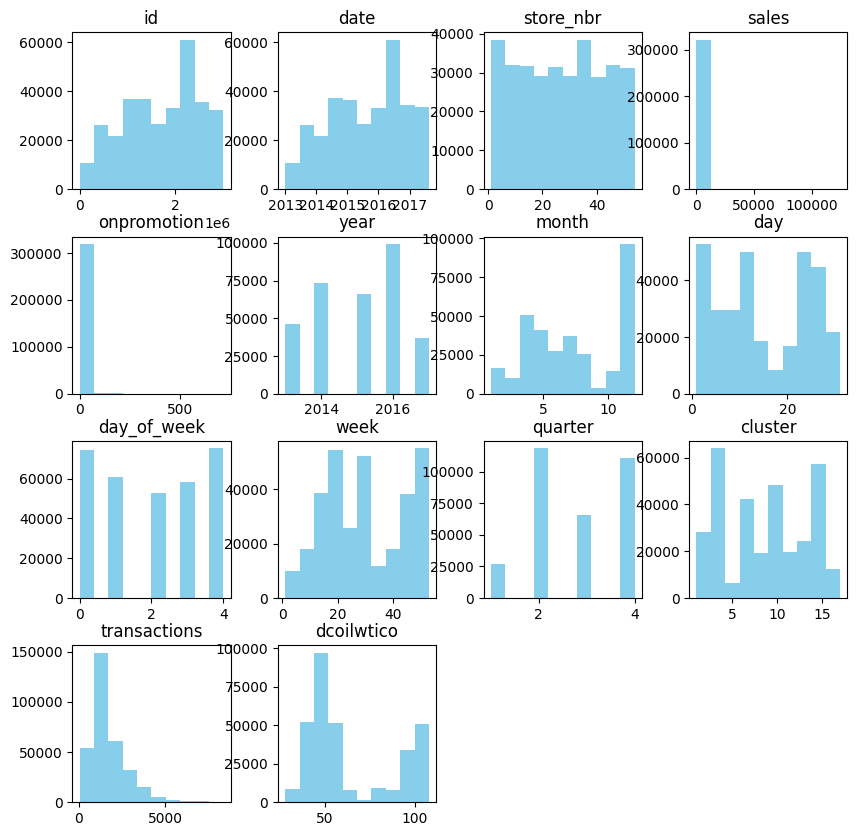

In [45]:
#plot the histograph for the  numerical columns
merged_data.hist(figsize=(10,10), grid=False, color='skyblue')
plt.show()


1. **id**: The distribution is relatively uniform with some peaks, indicating a varied range of unique identifiers but with certain ids appearing more frequently.
2. **date**: Dates are evenly distributed across the years from 2013 to 2017, showing consistent data collection over time.
3. **store_nbr**: The store numbers are relatively evenly distributed, indicating a uniform representation of stores in the dataset.
4. **sales**: A significant spike at a single value, suggesting that many sales transactions have the same or very similar amounts.
5. **onpromotion**: Most values are concentrated at zero, indicating that a large number of items were not on promotion, with a long tail showing fewer items with promotions.
6. **year**: Data is fairly evenly distributed across the years from 2013 to 2017, with a slightly lower count for the years towards the ends of the range.
7. **month**: Distribution across months appears mostly even, suggesting that the data does not have significant monthly seasonal variations.
8. **day**: Data is uniformly distributed across days of the month, indicating that the collection was consistent throughout each month.
9. **day_of_week**: The distribution across the days of the week is relatively even, with a slight decrease on weekends, suggesting slightly lower activity or fewer transactions on weekends.
10. **week**: The data shows a consistent distribution across weeks, indicating continuous data collection throughout the year.
11. **quarter**: Each quarter has a relatively even distribution, showing no significant seasonal bias in the data collection.
12. **cluster**: Distribution among clusters is varied but balanced, indicating that all clusters are well-represented in the dataset.
13. **transactions**: Most values are on the lower end, indicating a high frequency of transactions with smaller amounts, with a long tail of fewer, larger transactions.
14. **dcoilwtico**: The distribution of oil prices shows a normal distribution centered around a particular value, indicating typical fluctuations in oil prices within a certain range.

In [46]:
# Select only numerical columns
numerical_df = merged_data.select_dtypes(include=['number'])
numerical_df


,id,store_nbr,sales,onpromotion,year,month,day,day_of_week,week,quarter,cluster,transactions,dcoilwtico
0,73062.0,1.0,0.00000,0.0,2013,2,11,0,7,1,13,396,97.010002
1,73085.0,1.0,0.00000,0.0,2013,2,11,0,7,1,13,396,97.010002
2,73084.0,1.0,21.00000,0.0,2013,2,11,0,7,1,13,396,97.010002
3,73083.0,1.0,0.00000,0.0,2013,2,11,0,7,1,13,396,97.010002
4,73082.0,1.0,3.00000,0.0,2013,2,11,0,7,1,13,396,97.010002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
322042,1297888.0,25.0,0.00000,0.0,2015,1,1,3,1,1,1,2202,52.720001
322043,1297887.0,25.0,105.00000,0.0,2015,1,1,3,1,1,1,2202,52.720001
322044,1297886.0,25.0,121.94100,0.0,2015,1,1,3,1,1,1,2202,52.720001
322045,1297885.0,25.0,279.16998,0.0,2015,1,1,3,1,1,1,2202,52.720001


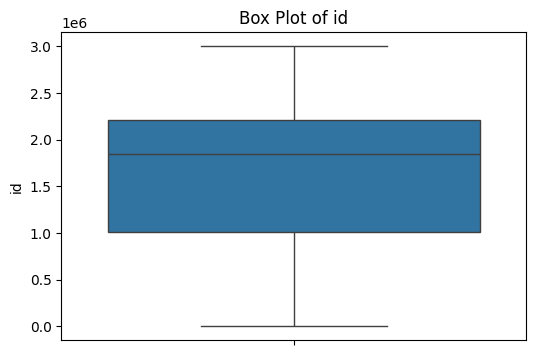

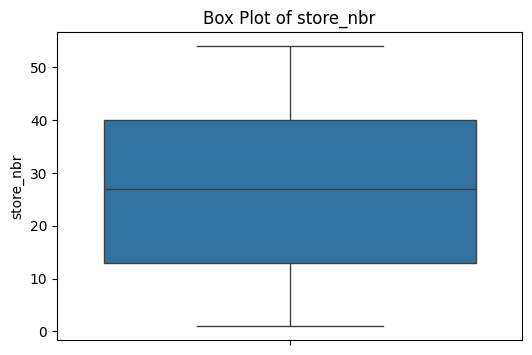

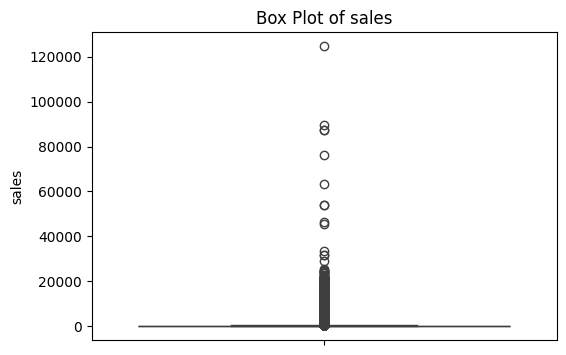

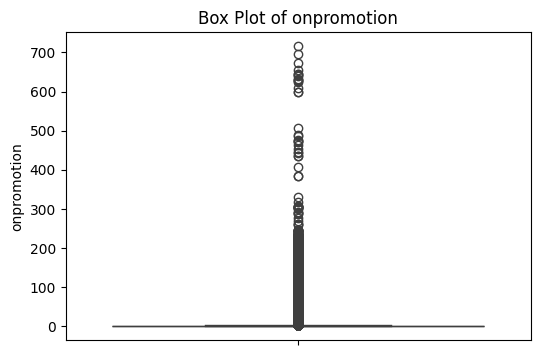

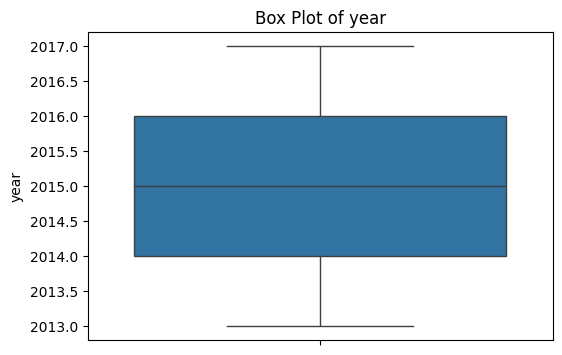

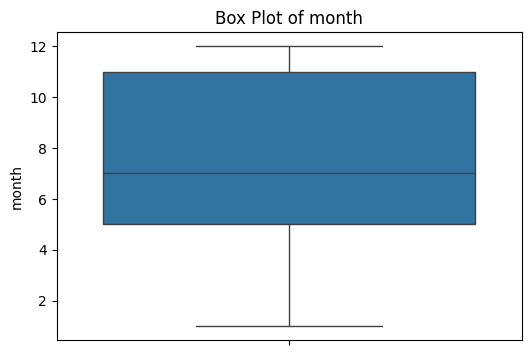

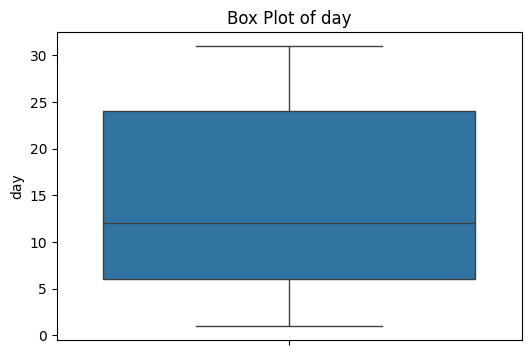

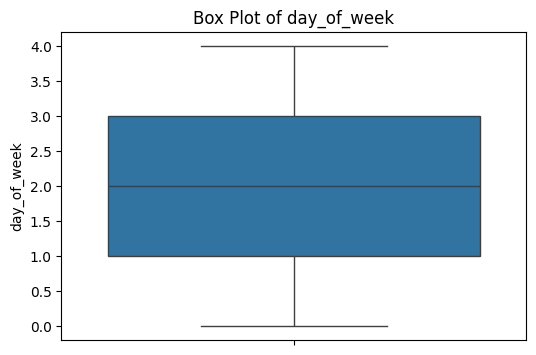

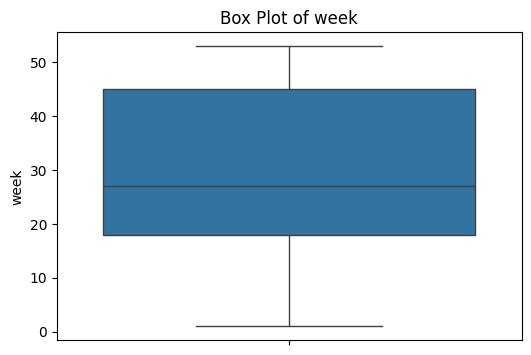

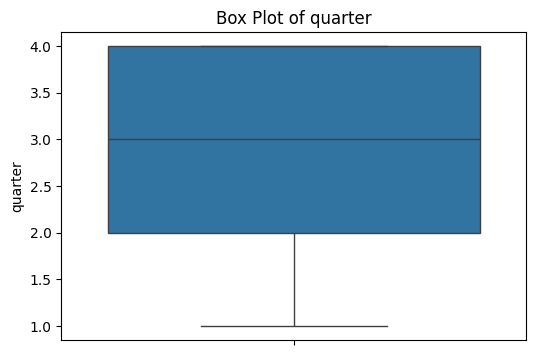

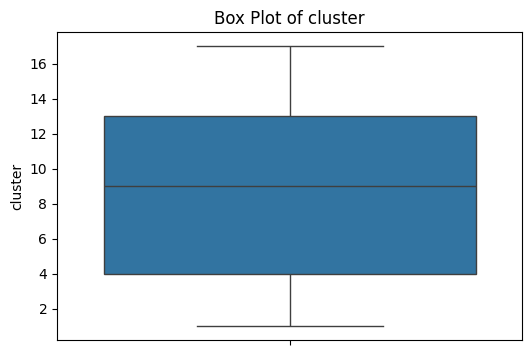

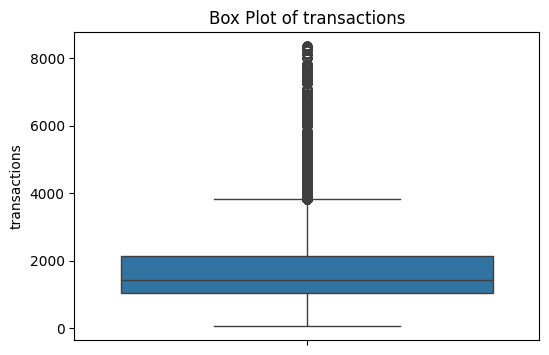

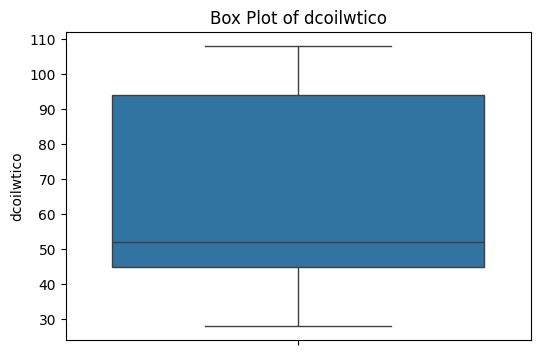

In [47]:
# Plotting box plots for each numerical column separately
for column in numerical_df.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=numerical_df[column])
    plt.title(f'Box Plot of {column}')
    plt.show()

**General Observations:**
- Right-Skewness: Many columns, particularly sales, transactions, and onpromotion, show right-skewed distributions. This indicates that these columns have many low values and a few high-value outliers.
- Uniform Distributions: Columns like store_nbr, year, and month show more uniform distributions, suggesting consistent data collection practices.
- Trends Over Time: The date column shows a trend of increasing entries over the years, which could indicate growing data collection efforts or business activity over time.
- Multimodality: The dcoilwtico column's distribution suggests multiple peaks, indicating that the data may have several distinct value ranges or categories.
- outliers: there are outliers in transactions, onpromotion and sales columns

In [48]:
merged_data.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year',
       'month', 'day', 'day_of_week', 'week', 'quarter', 'city', 'state',
       'store_type', 'cluster', 'transactions', 'holiday_type', 'locale',
       'locale_name', 'description', 'transferred', 'dcoilwtico'],
      dtype='object')

In [49]:
merged_data.shape

(322047, 23)

**BIVARIATE AND MULTIVARIATE ANALYSIS**

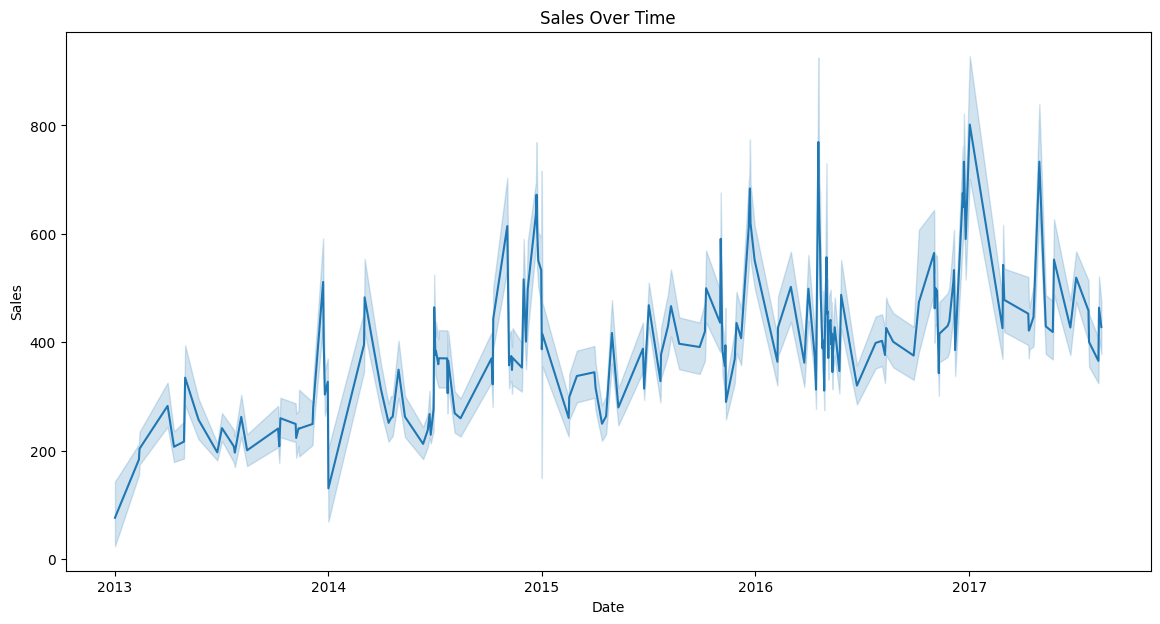

In [50]:
# Plot sales over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=merged_data, x='date', y='sales')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

- **Overall Trend**: Sales generally increase over the years, with some fluctuations.
- **Seasonal Peaks**: There are noticeable peaks at regular intervals, suggesting seasonal trends or periodic events influencing sales.
- **Variability**: The shaded area around the line indicates the confidence interval, showing the variability in sales. The variability appears to increase over time, particularly from 2015 onwards.
- **Spikes**: Several sharp spikes indicate periods of unusually high sales, possibly due to promotions, holidays, or other significant events.

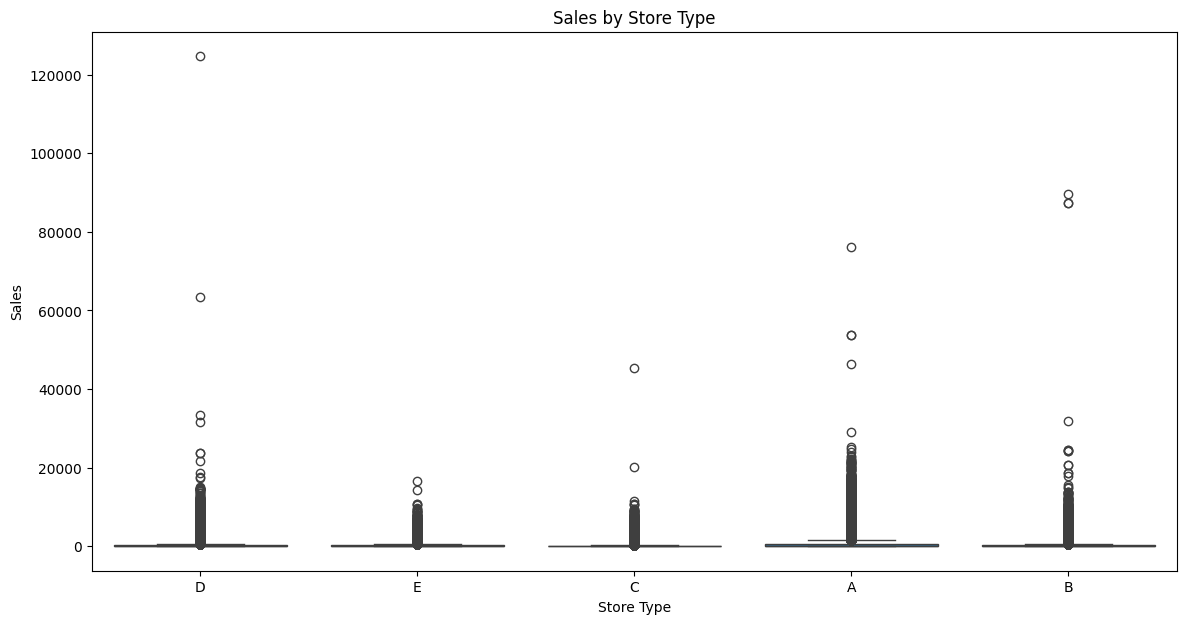

In [51]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=merged_data, x='store_type', y='sales')
plt.title('Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

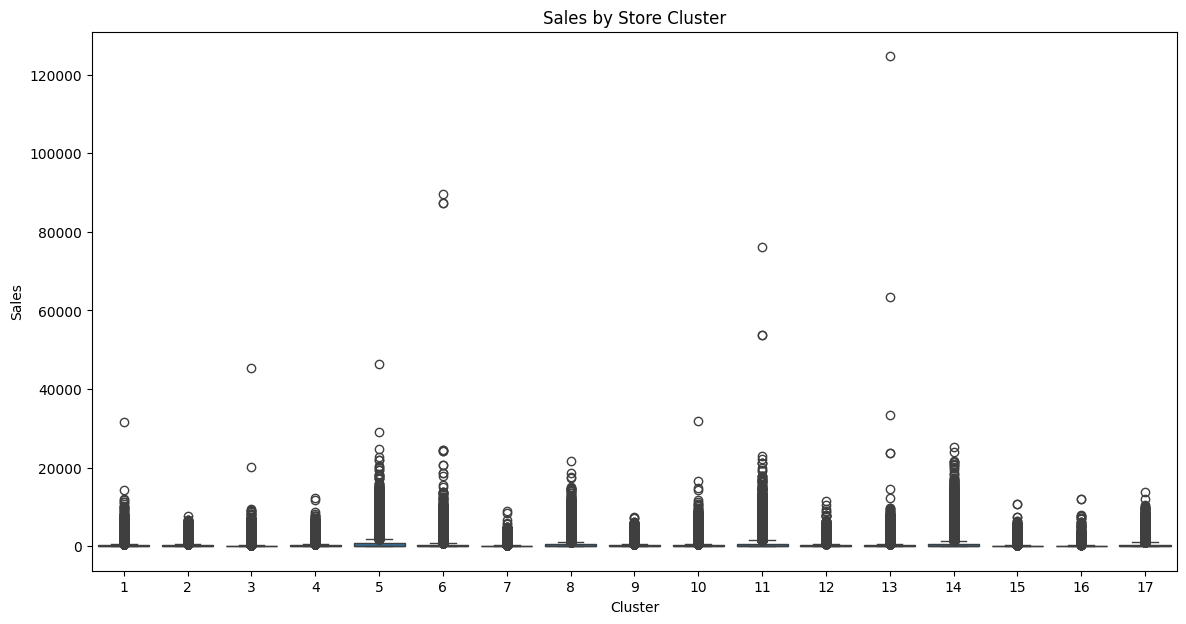

In [52]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=merged_data, x='cluster', y='sales')
plt.title('Sales by Store Cluster')
plt.xlabel('Cluster')
plt.ylabel('Sales')
plt.show()

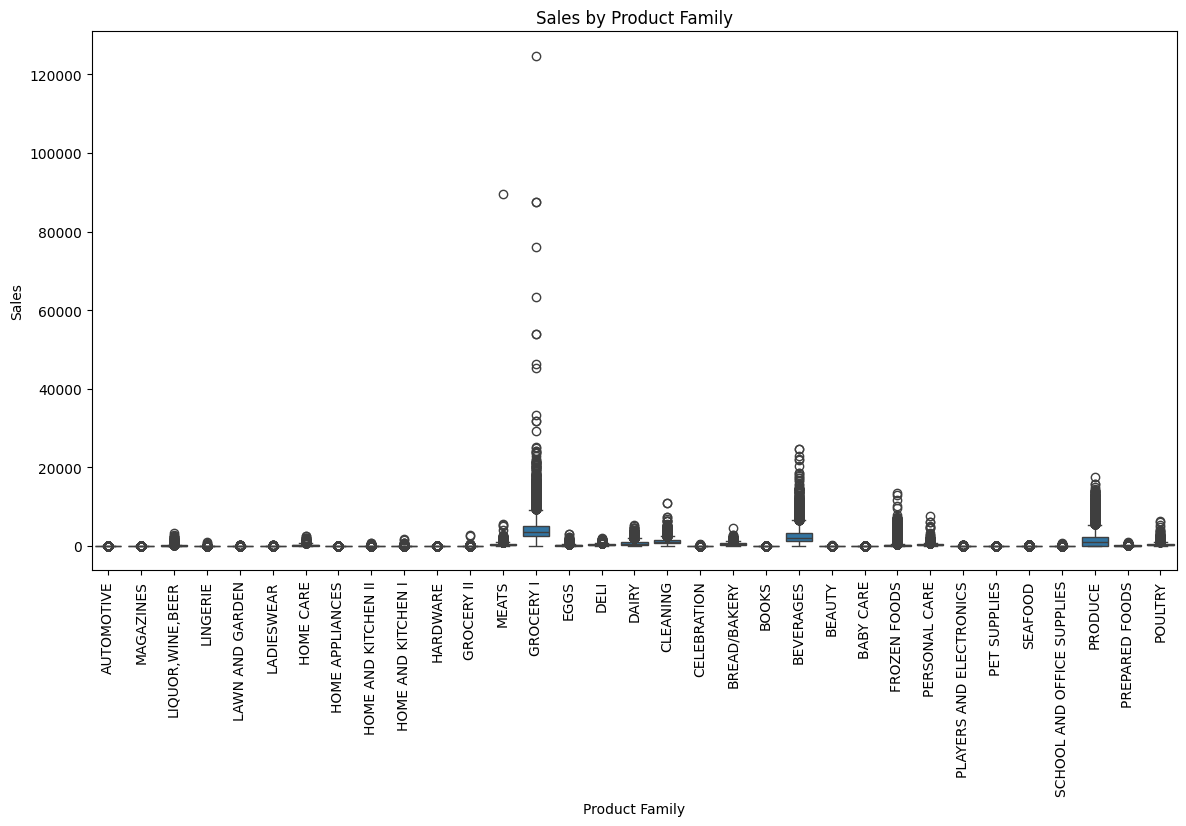

In [53]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=merged_data, x='family', y='sales')
plt.title('Sales by Product Family')
plt.xlabel('Product Family')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.show()

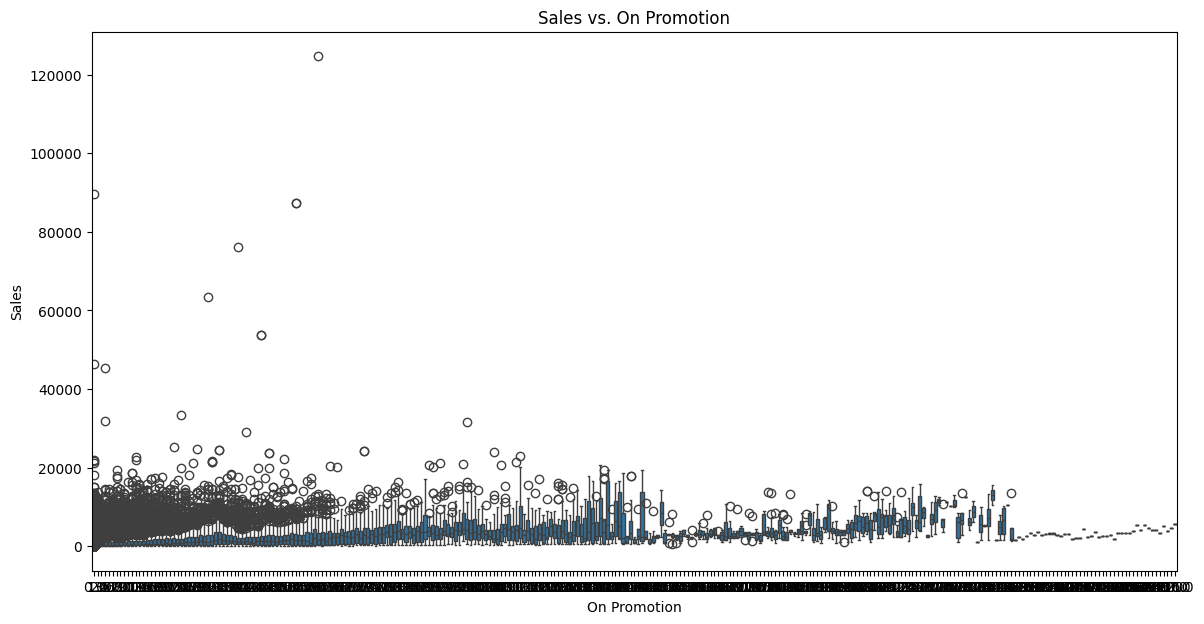

In [54]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=merged_data, x='onpromotion', y='sales')
plt.title('Sales vs. On Promotion')
plt.xlabel('On Promotion')
plt.ylabel('Sales')
plt.show()

## multivariate

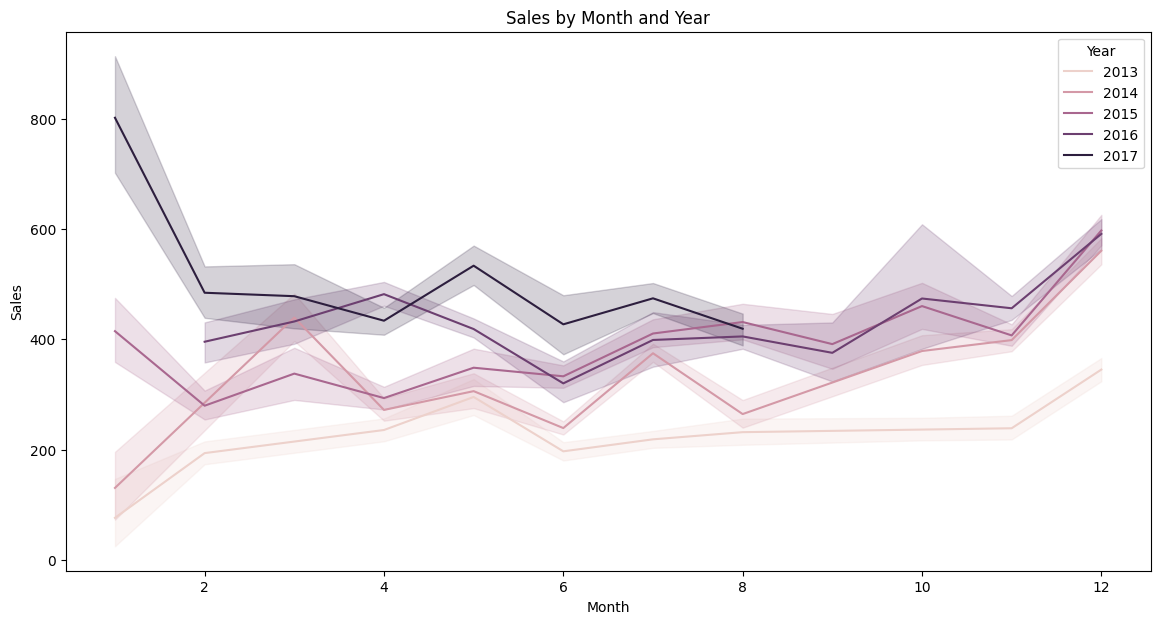

In [55]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=merged_data, x='month', y='sales', hue='year')
plt.title('Sales by Month and Year')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(title='Year')
plt.show()


This plot shows sales trends by month and year from 2013 to 2017. Key points include:

- **Seasonal Pattern**: Sales exhibit a seasonal pattern, with noticeable dips and peaks throughout the year.
- **Early Year Peaks**: Each year starts with high sales in January, followed by a decline in the following months.
- **Mid-Year Consistency**: Sales generally stabilize from April to August across all years.
- **End of Year Rise**: Sales increase towards the end of the year, particularly in December, likely due to holiday shopping.
- **Yearly Comparison**: 
  - Sales in 2016 (darkest line) are generally higher than other years, indicating a particularly strong year.
  - 2013 (lightest line) shows the lowest sales throughout the year, reflecting an overall growth in sales over the years.
- **Confidence Intervals**: The shaded areas indicate variability, with 2016 showing higher variability, especially at the beginning and end of the year.

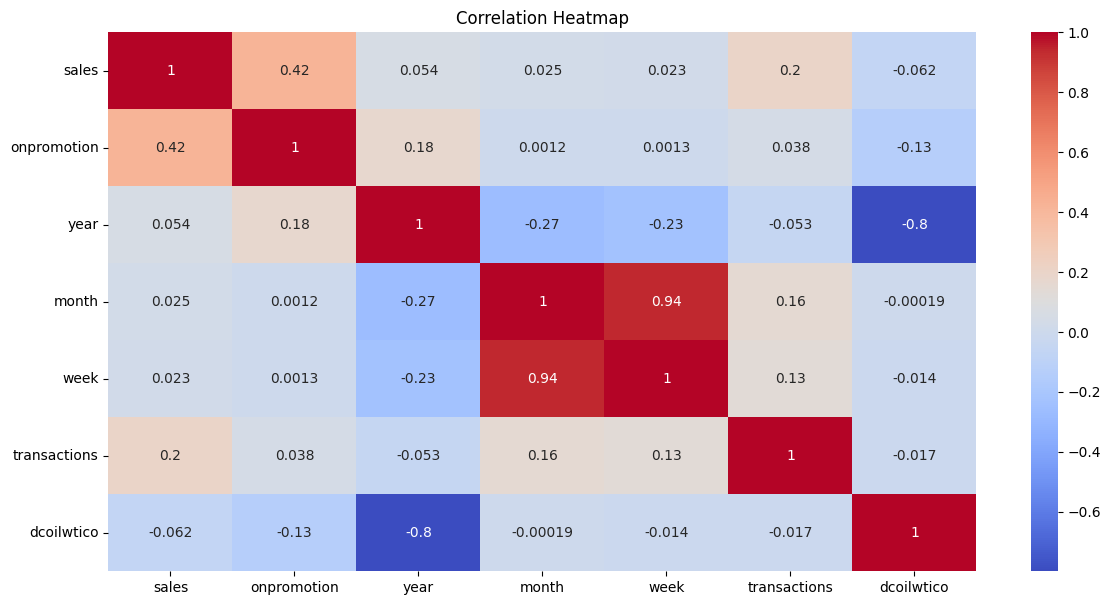

In [56]:
# Selecting relevant numerical columns
numerical_cols = ['sales', 'onpromotion', 'year', 'month', 'week', 'transactions', 'dcoilwtico']

plt.figure(figsize=(14, 7))
sns.heatmap(merged_data[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


- **Sales and Onpromotion**: There's a moderate positive correlation (0.42) indicating that when more items are on promotion, sales tend to increase.
- **Month and Week**: Both month and week have a very high correlation with each other (0.94), which is expected since weeks are nested within months.
- **Year and Dcoilwtico**: A strong negative correlation (-0.8) suggests that as the year progresses, the dcoilwtico (possibly an oil price index) tends to decrease.
- **Year and Sales/Onpromotion**: The correlations are relatively low with year, suggesting that there is little direct yearly trend affecting sales or promotions.

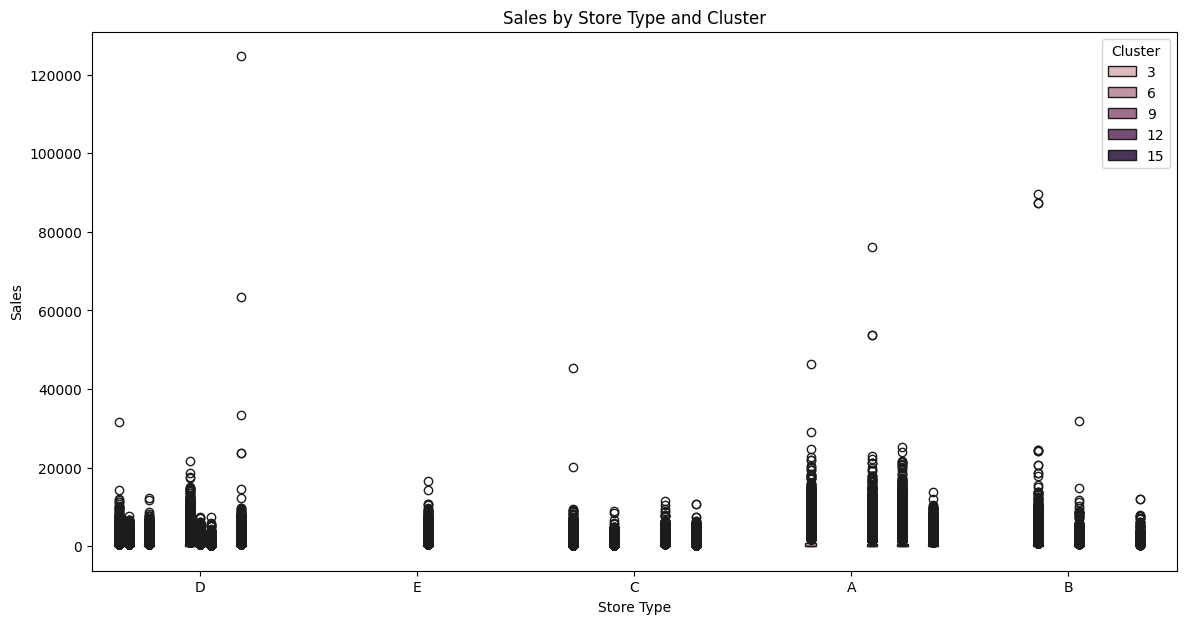

In [57]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=merged_data, x='store_type', y='sales', hue='cluster')
plt.title('Sales by Store Type and Cluster')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.legend(title='Cluster')
plt.show()


**Hypothesis Testing**

Hypothesis

- Null Hypothesis: Promotions do not have a significant effect on the sales of products.
- Alternative Hypothesis: Promotions have a significant effect on the sales of products. 

In [58]:
# Define if promotion is active (more than 0 items promoted)
merged_data['is_promotion_active'] = merged_data['onpromotion'] > 0

# Split the data into sales with promotions and without promotions
promotion_sales = merged_data[merged_data['is_promotion_active']]['sales']
no_promotion_sales = merged_data[~merged_data['is_promotion_active']]['sales']

# Perform a t-test to see if there's a significant difference in sales
t_stat, p_val = ttest_ind(promotion_sales, no_promotion_sales)

# Print results
print(f'T-statistic: {t_stat:.4f}')
print(f'P-value: {p_val:.4f}')

# Interpretation
alpha = 0.05
if p_val < alpha:
    print("Reject the null hypothesis: Promotions have a significant effect on sales.")
else:
    print("Fail to reject the null hypothesis: Promotions do not have a significant effect on sales.")

T-statistic: 208.3956
P-value: 0.0000
Reject the null hypothesis: Promotions have a significant effect on sales.


**Analytical Questions**

1. Is the train dataset complete (has all the required dates)?

In [59]:
# Generate the complete date range
complete_date_range = pd.date_range(start=train_data['date'].min(), end=train_data['date'].max())

# Check for missing dates
missing_dates = complete_date_range.difference(train_data['date'].unique())

# Output the results
print(f"Minimum date in the dataset: {train_data['date'].min()}")
print(f"Maximum date in the dataset: {train_data['date'].max()}")
print(f"Number of missing dates: {len(missing_dates)}")
print(f"Missing dates: {missing_dates}")

Minimum date in the dataset: 2013-01-01 00:00:00
Maximum date in the dataset: 2017-08-15 00:00:00
Number of missing dates: 0
Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?

In [60]:
# Group the data by year and date, and sum the sales for each date
sales_per_day = merged_data.groupby(['year', 'date'])['sales'].sum().reset_index()

# Exclude days with zero sales (assuming these are the days the store was closed)
sales_per_day = sales_per_day[sales_per_day['sales'] > 0]

# Find the dates with the lowest and highest sales for each year
lowest_sales = sales_per_day.loc[sales_per_day.groupby('year')['sales'].idxmin()]
highest_sales = sales_per_day.loc[sales_per_day.groupby('year')['sales'].idxmax()]

# Display the results
print("Dates with the lowest sales for each year:")
print(lowest_sales)
print("\nDates with the highest sales for each year:")
print(highest_sales)

Dates with the lowest sales for each year:
     year       date          sales
0    2013 2013-01-01    2511.618999
28   2014 2014-01-01    8602.065404
70   2015 2015-01-01   12773.616980
121  2016 2016-04-28  543339.849013
176  2017 2017-08-10  651386.911970

Dates with the highest sales for each year:
     year       date         sales
8    2013 2013-06-25  9.153586e+05
65   2014 2014-12-22  2.016287e+06
102  2015 2015-12-22  2.283724e+06
157  2016 2016-12-22  2.271699e+06
173  2017 2017-07-03  1.850287e+06


3. Compare the sales for each month across the years and determine which month of which year had the highest sales.

In [61]:
# Group the data by year and month, and sum the sales for each month
monthly_sales = merged_data.groupby(['year', 'month'])['sales'].sum().reset_index()

# Find the month with the highest sales
highest_sales_month = monthly_sales.loc[monthly_sales['sales'].idxmax()]

# Display the results
print("Monthly sales comparison across the years:")
print(monthly_sales)
print("\nMonth with the highest sales:")
print(highest_sales_month)

Monthly sales comparison across the years:
    year  month         sales
0   2013      1  2.511619e+03
1   2013      2  5.874284e+05
2   2013      4  1.072007e+06
3   2013      5  9.063639e+05
4   2013      6  9.153586e+05
5   2013      7  1.672679e+06
6   2013      8  7.180770e+05
7   2013     10  1.098830e+06
8   2013     11  1.480086e+06
9   2013     12  3.210593e+06
10  2014      1  8.602065e+03
11  2014      3  1.362904e+06
12  2014      4  1.659536e+06
13  2014      5  9.286327e+05
14  2014      6  2.964238e+06
15  2014      7  5.253892e+06
16  2014      8  8.198293e+05
17  2014     10  1.799401e+06
18  2014     11  4.418237e+06
19  2014     12  8.878967e+06
20  2015      1  6.705370e+05
21  2015      2  9.038290e+05
22  2015      3  5.460378e+05
23  2015      4  1.897162e+06
24  2015      5  1.126672e+06
25  2015      6  2.196425e+06
26  2015      7  2.722302e+06
27  2015      8  2.191401e+06
28  2015      9  6.712611e+05
29  2015     10  1.594497e+06
30  2015     11  5.694471e+

4. Did the earthquake impact sales?

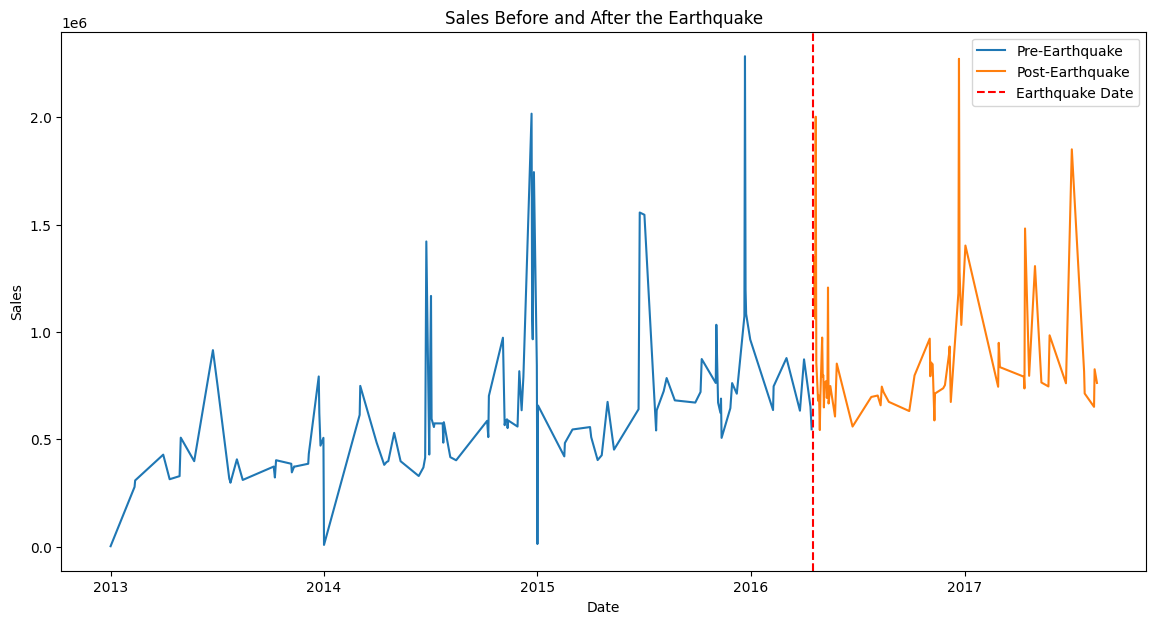

Average sales before the earthquake: 639405.18
Average sales after the earthquake: 888208.89


In [62]:
# Define the earthquake date
earthquake_date = pd.to_datetime('2016-04-16')

# Create a flag for pre- and post-earthquake periods
merged_data['earthquake_impact'] = merged_data['date'].apply(lambda x: 'Post-Earthquake' if x >= earthquake_date else 'Pre-Earthquake')

# Group the data by date and sum the sales for each date
daily_sales = merged_data.groupby('date')['sales'].sum().reset_index()

# Merge with earthquake impact flag
daily_sales = daily_sales.merge(merged_data[['date', 'earthquake_impact']].drop_duplicates(), on='date')

# Plot sales before and after the earthquake
plt.figure(figsize=(14, 7))
sns.lineplot(data=daily_sales, x='date', y='sales', hue='earthquake_impact')
plt.axvline(x=earthquake_date, color='r', linestyle='--', label='Earthquake Date')
plt.title('Sales Before and After the Earthquake')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Calculate average sales before and after the earthquake
pre_earthquake_sales = daily_sales[daily_sales['earthquake_impact'] == 'Pre-Earthquake']['sales'].mean()
post_earthquake_sales = daily_sales[daily_sales['earthquake_impact'] == 'Post-Earthquake']['sales'].mean()

print(f"Average sales before the earthquake: {pre_earthquake_sales:.2f}")
print(f"Average sales after the earthquake: {post_earthquake_sales:.2f}")

5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)

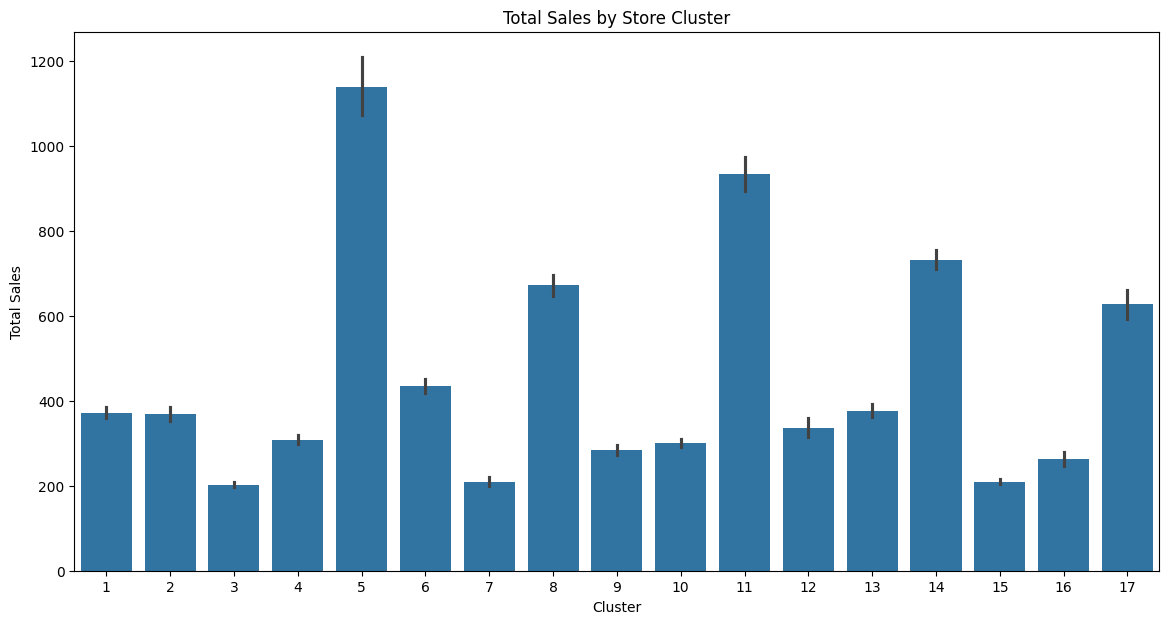

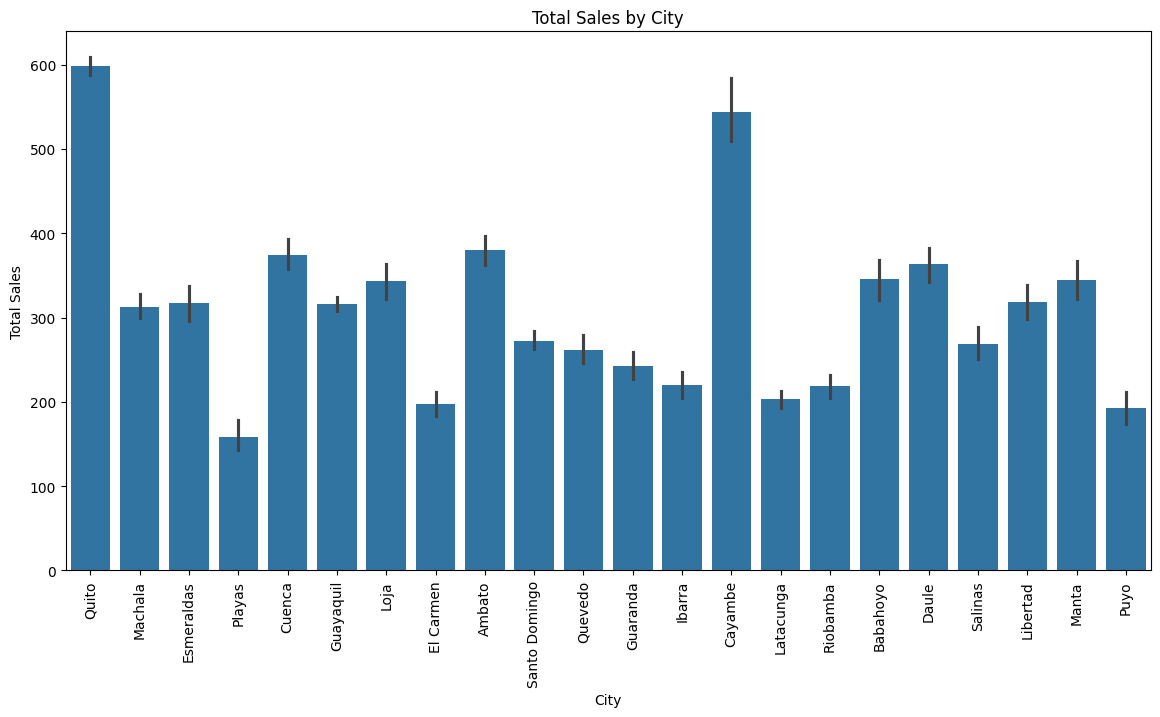

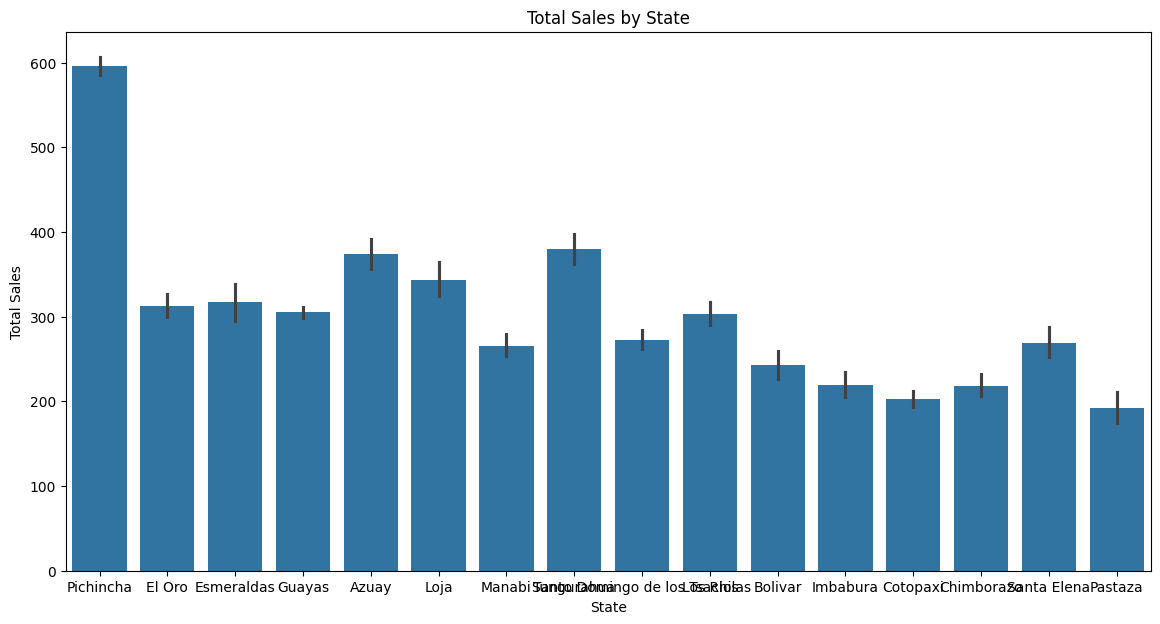

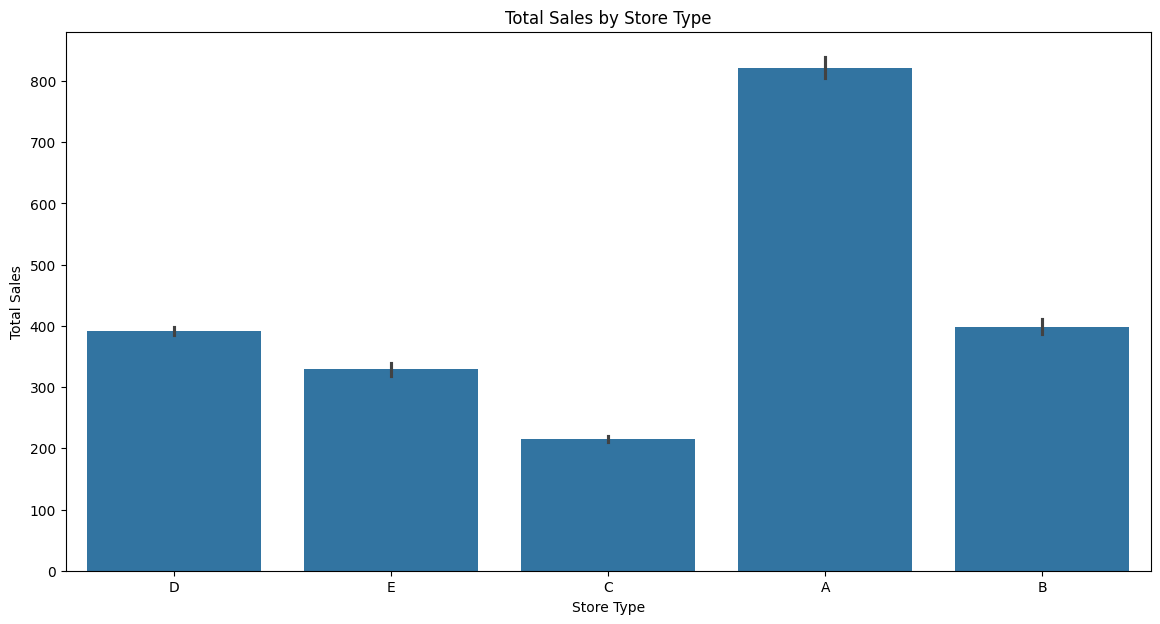

Top 10 stores by total sales:
    store_nbr         sales
43       44.0  7.297347e+06
44       45.0  6.646578e+06
46       47.0  6.052432e+06
2         3.0  5.985505e+06
48       49.0  5.388407e+06
45       46.0  5.016086e+06
47       48.0  4.247941e+06
50       51.0  4.020780e+06
7         8.0  3.571102e+06
10       11.0  3.485479e+06


In [63]:
# Plot sales by cluster
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_data, x='cluster', y='sales')
plt.title('Total Sales by Store Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Sales')
plt.show()

# Plot sales by city
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_data, x='city', y='sales')
plt.title('Total Sales by City')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.show()

# Plot sales by state
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_data, x='state', y='sales')
plt.title('Total Sales by State')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.show()

# Plot sales by store type
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_data, x='store_type', y='sales')
plt.title('Total Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Total Sales')
plt.show()

# Display top stores in terms of total sales
top_stores = merged_data.groupby('store_nbr')['sales'].sum().reset_index().sort_values(by='sales', ascending=False).head(10)
print("Top 10 stores by total sales:")
print(top_stores)

6. Are sales affected by promotions, oil prices and holidays?

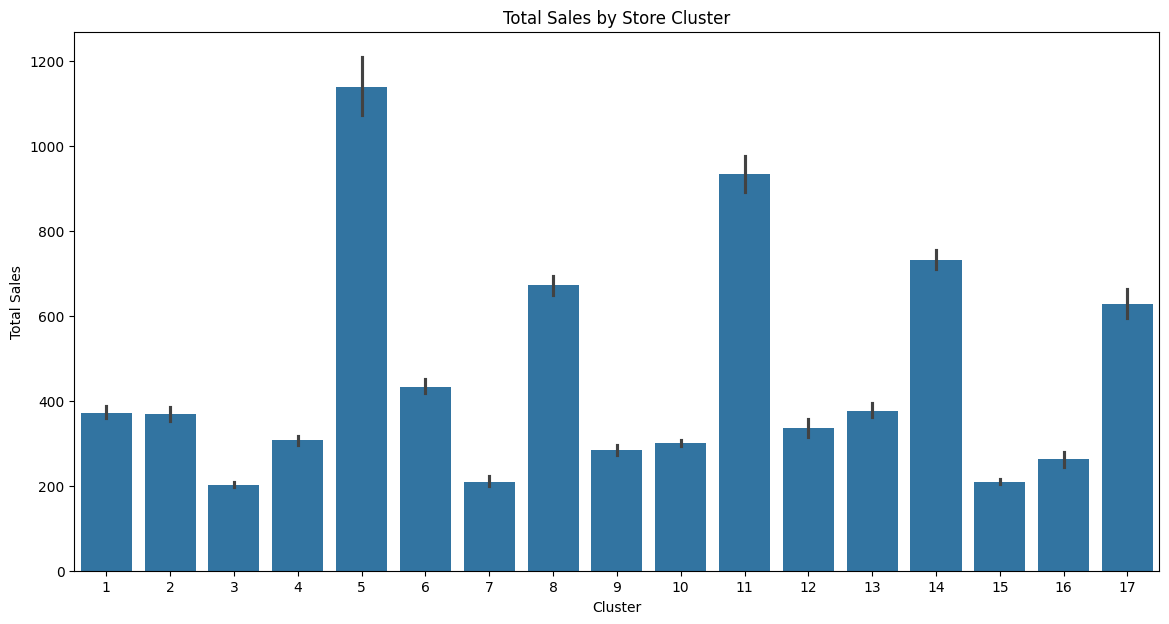

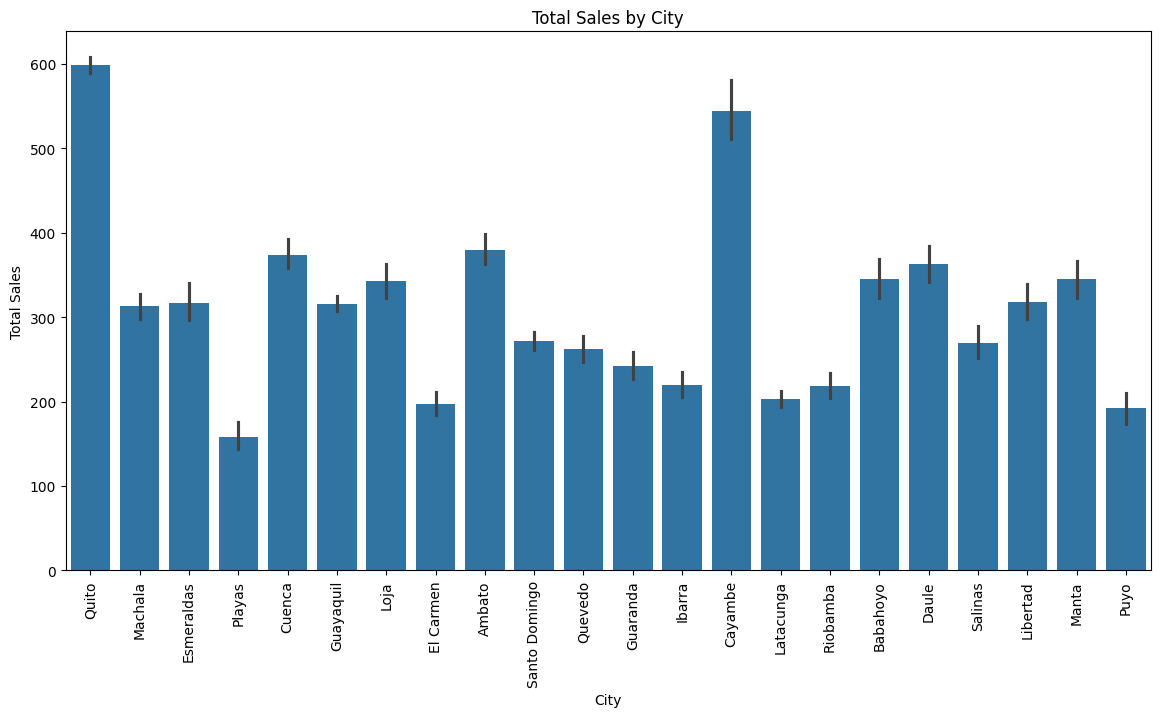

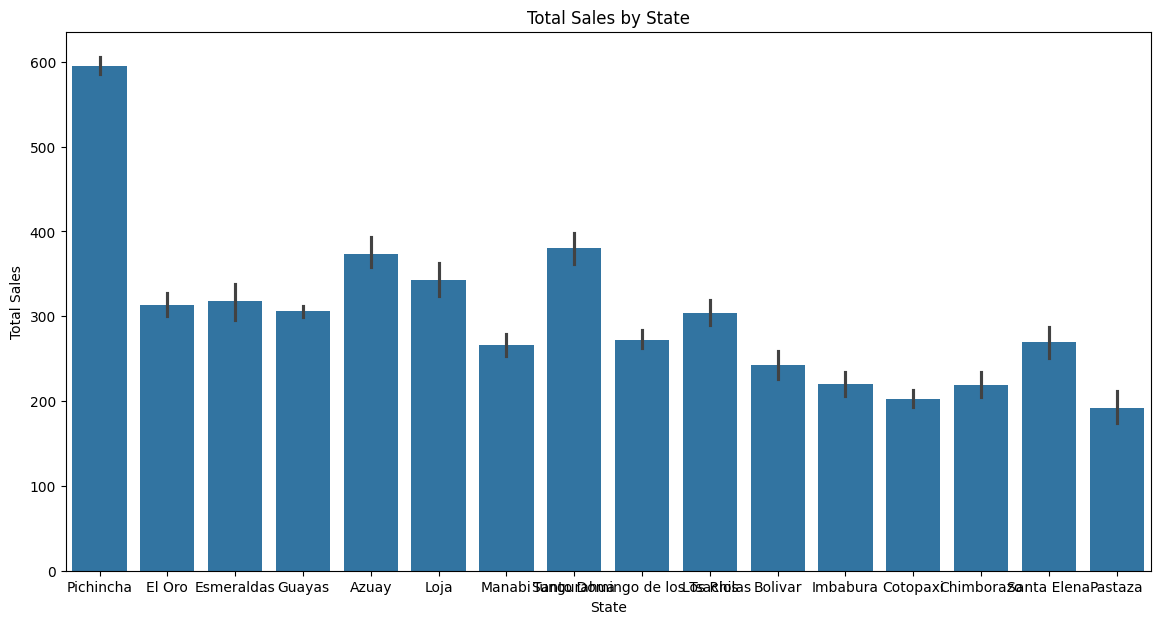

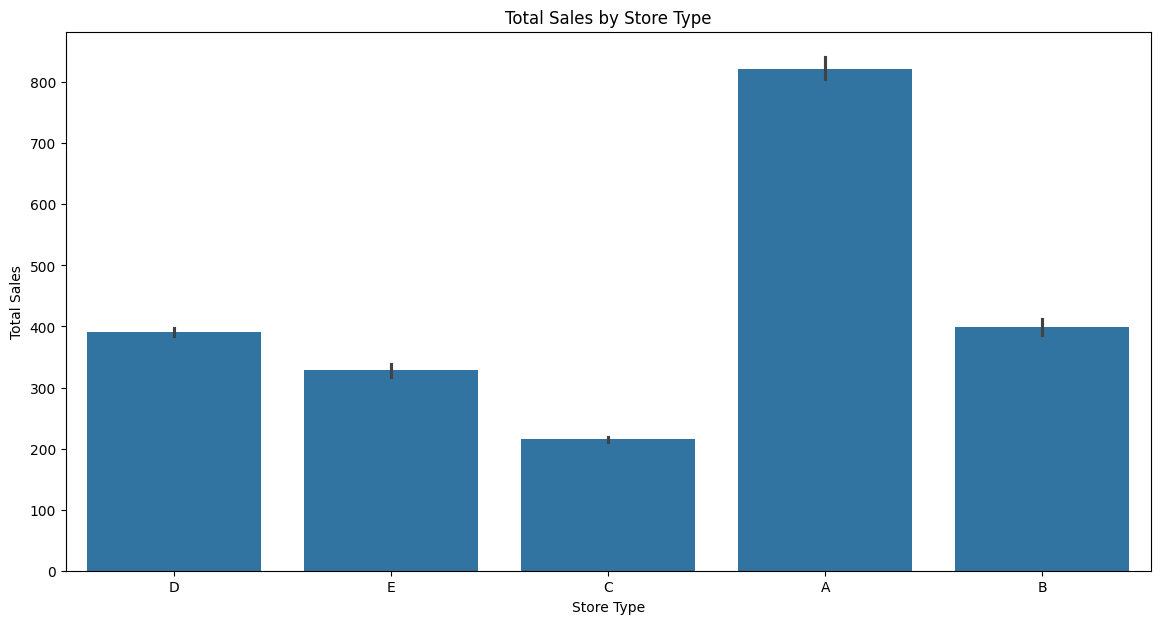

Top 10 stores by total sales:
    store_nbr         sales
43       44.0  7.297347e+06
44       45.0  6.646578e+06
46       47.0  6.052432e+06
2         3.0  5.985505e+06
48       49.0  5.388407e+06
45       46.0  5.016086e+06
47       48.0  4.247941e+06
50       51.0  4.020780e+06
7         8.0  3.571102e+06
10       11.0  3.485479e+06


In [64]:
# Plot sales by cluster
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_data, x='cluster', y='sales')
plt.title('Total Sales by Store Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Sales')
plt.show()

# Plot sales by city
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_data, x='city', y='sales')
plt.title('Total Sales by City')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.show()

# Plot sales by state
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_data, x='state', y='sales')
plt.title('Total Sales by State')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.show()

# Plot sales by store type
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_data, x='store_type', y='sales')
plt.title('Total Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Total Sales')
plt.show()

# Display top stores in terms of total sales
top_stores = merged_data.groupby('store_nbr')['sales'].sum().reset_index().sort_values(by='sales', ascending=False).head(10)
print("Top 10 stores by total sales:")
print(top_stores)

7. What analysis can we get from the date and its extractable features?

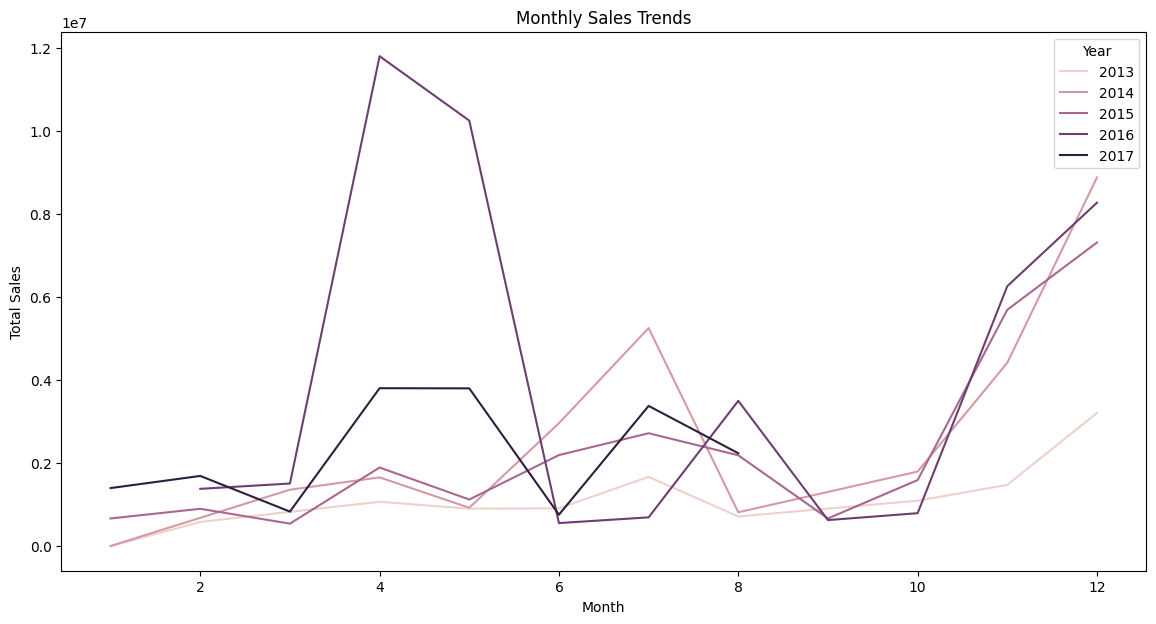

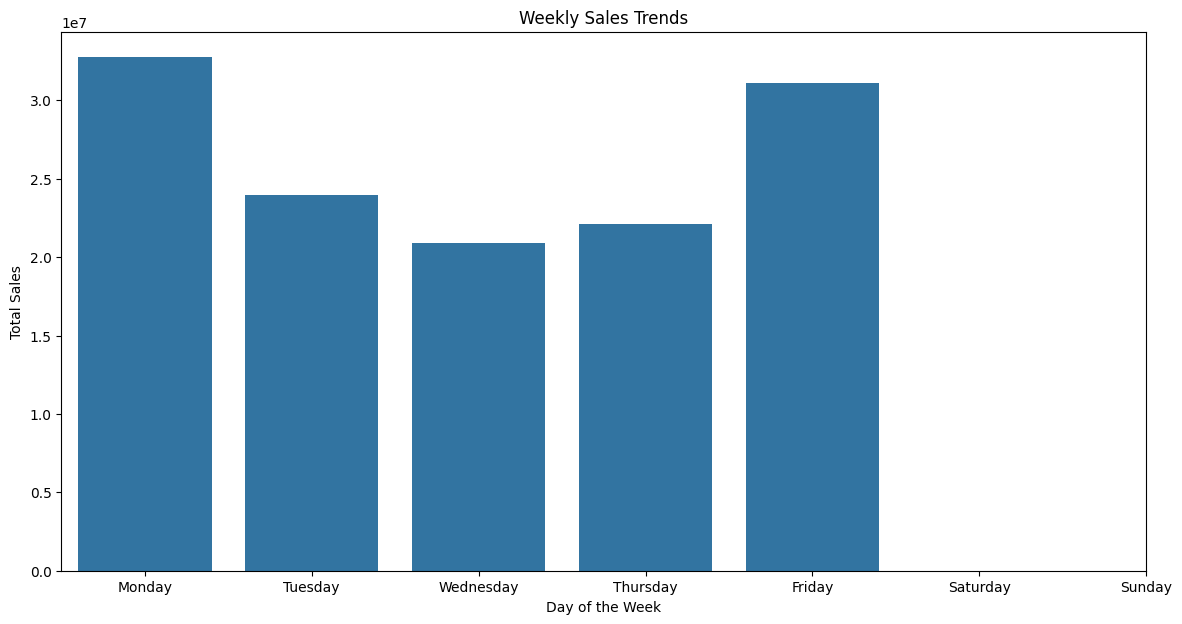

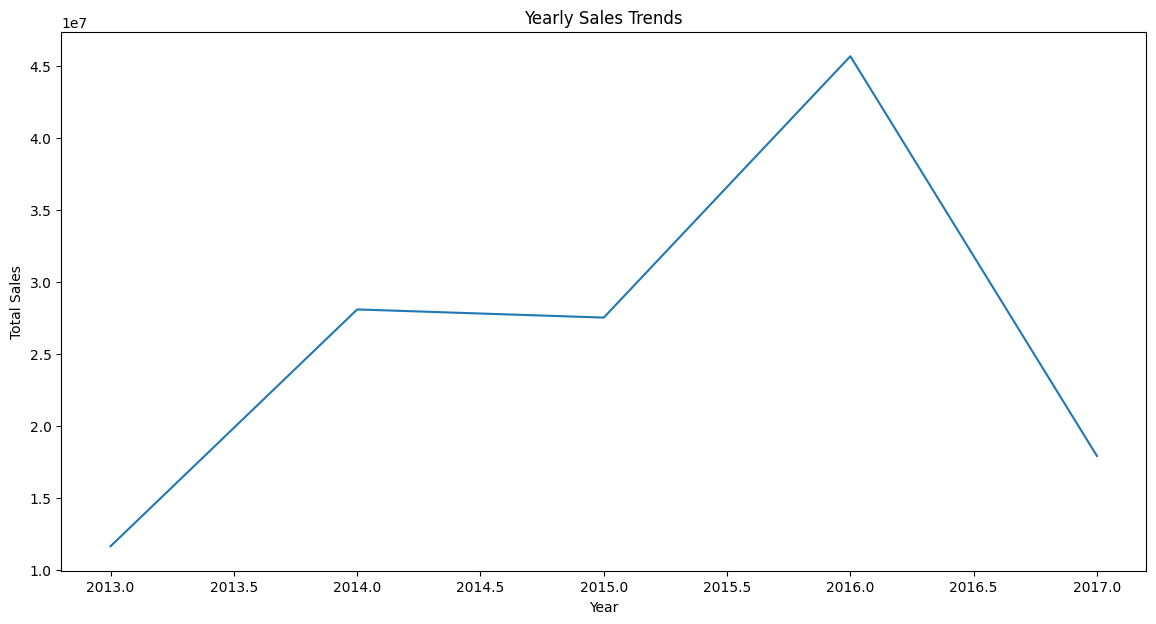

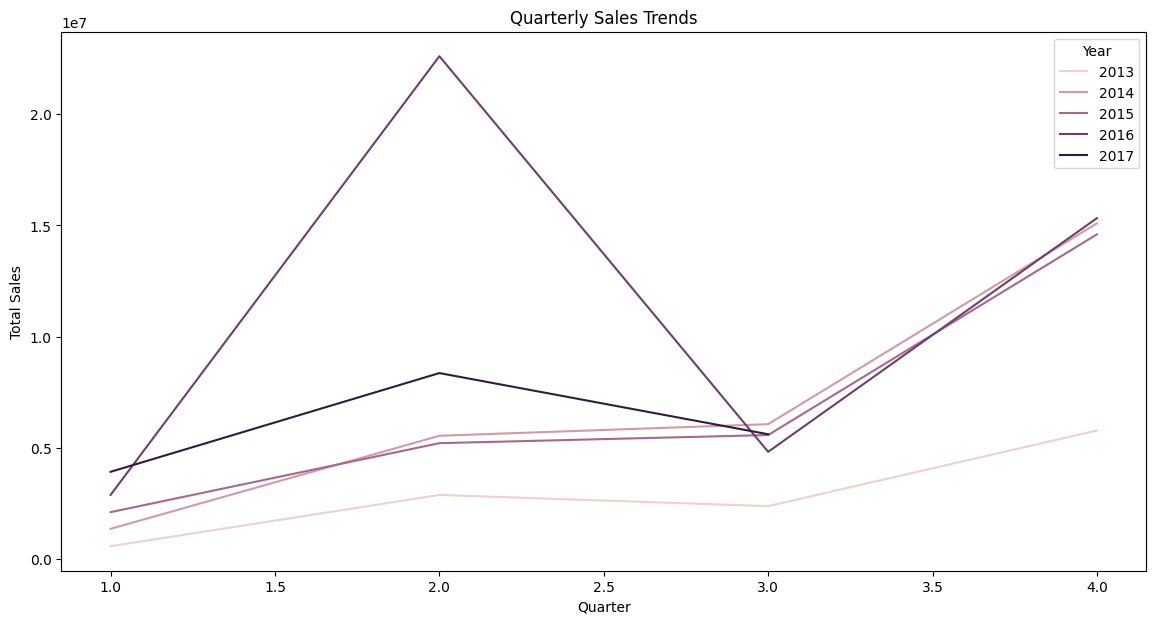

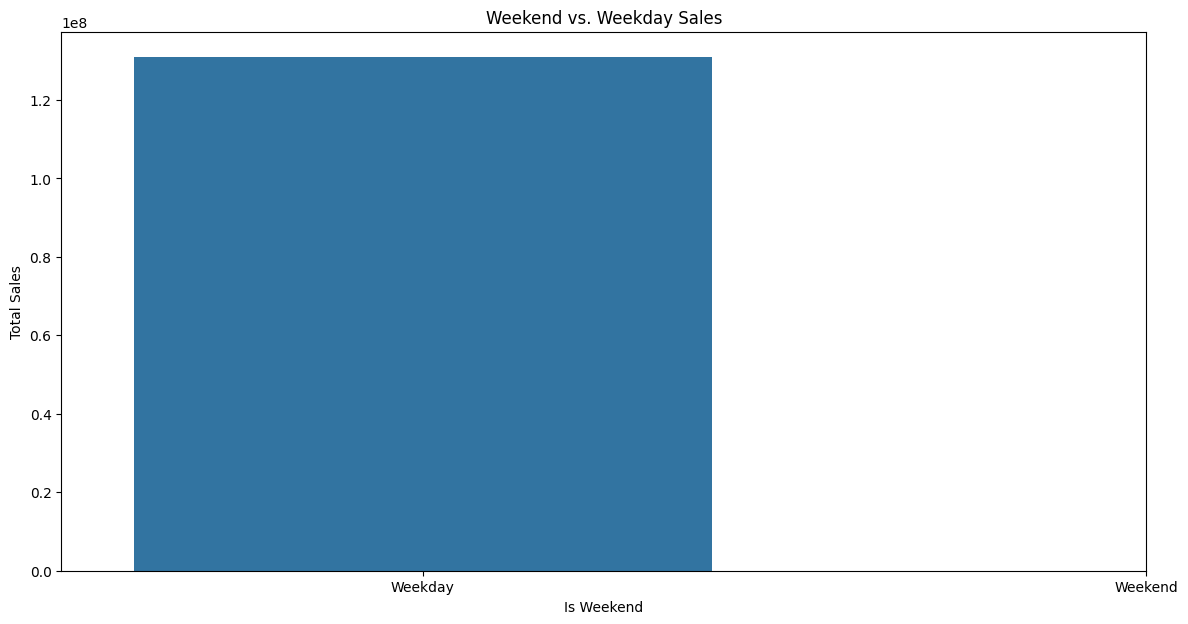

In [65]:
# Monthly Sales Trends
monthly_sales = merged_data.groupby(['year', 'month'])['sales'].sum().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_sales, x='month', y='sales', hue='year')
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Year')
plt.show()

# Weekly Sales Trends
weekly_sales = merged_data.groupby(['day_of_week'])['sales'].sum().reset_index()
plt.figure(figsize=(14, 7))
sns.barplot(data=weekly_sales, x='day_of_week', y='sales')
plt.title('Weekly Sales Trends')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

# Yearly Sales Trends
yearly_sales = merged_data.groupby('year')['sales'].sum().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(data=yearly_sales, x='year', y='sales')
plt.title('Yearly Sales Trends')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.show()

# Quarterly Sales Trends
quarterly_sales = merged_data.groupby(['year', 'quarter'])['sales'].sum().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(data=quarterly_sales, x='quarter', y='sales', hue='year')
plt.title('Quarterly Sales Trends')
plt.xlabel('Quarter')
plt.ylabel('Total Sales')
plt.legend(title='Year')
plt.show()

# Weekend vs. Weekday Sales
merged_data['is_weekend'] = merged_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
weekend_sales = merged_data.groupby('is_weekend')['sales'].sum().reset_index()
plt.figure(figsize=(14, 7))
sns.barplot(data=weekend_sales, x='is_weekend', y='sales')
plt.title('Weekend vs. Weekday Sales')
plt.xlabel('Is Weekend')
plt.ylabel('Total Sales')
plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'])
plt.show()

8. Which product family and stores did the promotions affect.

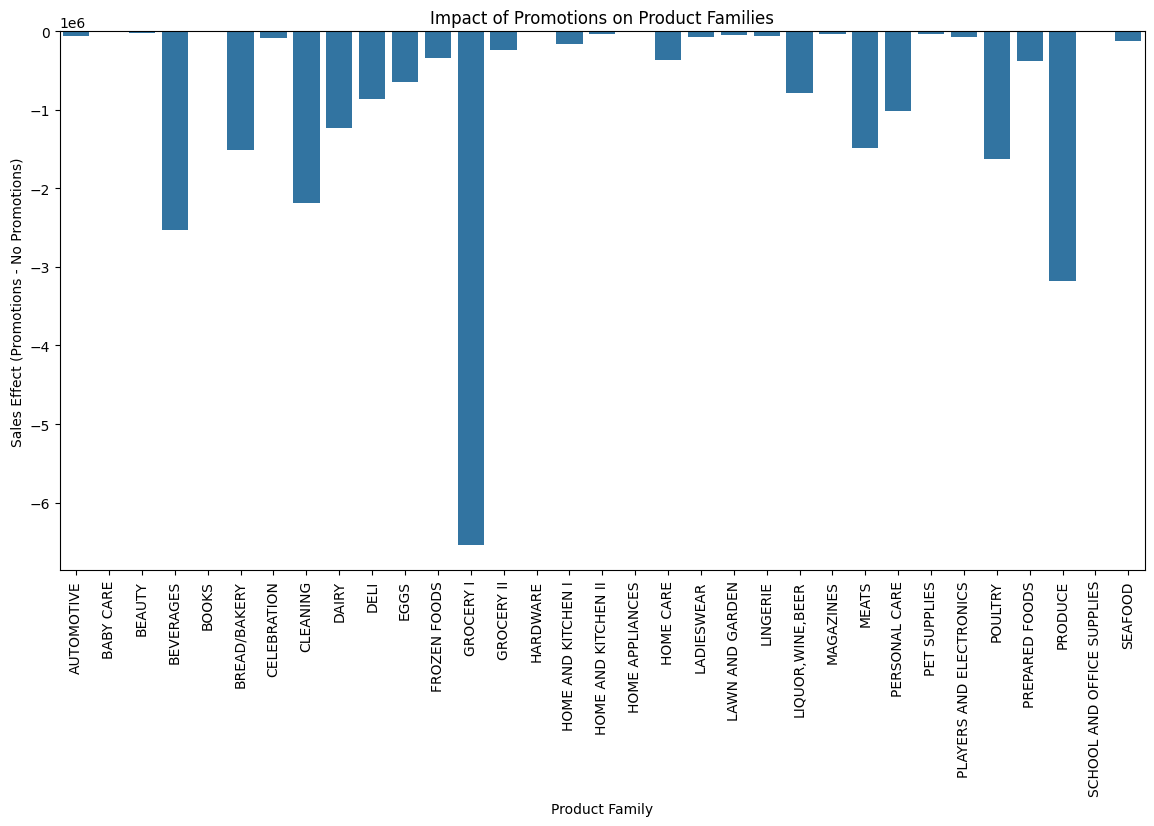

In [66]:


# Analyze the impact of promotions on product families
product_family_sales = merged_data.groupby(['family', 'onpromotion'])['sales'].sum().reset_index()

# Create a pivot table to compare sales with and without promotions for each product family
pivot_family = merged_data.pivot_table(index='family', columns='onpromotion', values='sales', aggfunc='sum', fill_value=0)
pivot_family['promo_effect'] = pivot_family[1] - pivot_family[0]

# Plot sales by product family
plt.figure(figsize=(14, 7))
sns.barplot(x=pivot_family.index, y=pivot_family['promo_effect'])
plt.title('Impact of Promotions on Product Families')
plt.xlabel('Product Family')
plt.ylabel('Sales Effect (Promotions - No Promotions)')
plt.xticks(rotation=90)
plt.show()



**FEATURE ENGINEERING**

### Train Dataset.
Extracting Date Components (Day, Month, Year and Day of The Week)

In [67]:
# Extracting Date Components
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data['year'] = merged_data['date'].dt.year
merged_data['month'] = merged_data['date'].dt.month
merged_data['day'] = merged_data['date'].dt.day
merged_data.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,...,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico,is_promotion_active,earthquake_impact,is_weekend
0,73062.0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,2013,2,11,0,...,396,Holiday,National,Ecuador,Carnaval,False,97.010002,False,Pre-Earthquake,0
1,73085.0,2013-02-11,1.0,MAGAZINES,0.0,0.0,2013,2,11,0,...,396,Holiday,National,Ecuador,Carnaval,False,97.010002,False,Pre-Earthquake,0
2,73084.0,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,2013,2,11,0,...,396,Holiday,National,Ecuador,Carnaval,False,97.010002,False,Pre-Earthquake,0
3,73083.0,2013-02-11,1.0,LINGERIE,0.0,0.0,2013,2,11,0,...,396,Holiday,National,Ecuador,Carnaval,False,97.010002,False,Pre-Earthquake,0
4,73082.0,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,2013,2,11,0,...,396,Holiday,National,Ecuador,Carnaval,False,97.010002,False,Pre-Earthquake,0


In [68]:
columns_to_drop = ['date','id', 'locale', 'locale_name', 'description', 'store_type', 'transferred', 'state', 'day_of_week']
merged_data = merged_data.drop(columns=columns_to_drop)

merged_data.head()

,store_nbr,family,sales,onpromotion,year,month,day,week,quarter,city,cluster,transactions,holiday_type,dcoilwtico,is_promotion_active,earthquake_impact,is_weekend
0,1.0,AUTOMOTIVE,0.0,0.0,2013,2,11,7,1,Quito,13,396,Holiday,97.010002,False,Pre-Earthquake,0
1,1.0,MAGAZINES,0.0,0.0,2013,2,11,7,1,Quito,13,396,Holiday,97.010002,False,Pre-Earthquake,0
2,1.0,"LIQUOR,WINE,BEER",21.0,0.0,2013,2,11,7,1,Quito,13,396,Holiday,97.010002,False,Pre-Earthquake,0
3,1.0,LINGERIE,0.0,0.0,2013,2,11,7,1,Quito,13,396,Holiday,97.010002,False,Pre-Earthquake,0
4,1.0,LAWN AND GARDEN,3.0,0.0,2013,2,11,7,1,Quito,13,396,Holiday,97.010002,False,Pre-Earthquake,0


**Product Categorization**

In [69]:
unique_families = merged_data['family'].unique()
unique_families

array(['AUTOMOTIVE', 'MAGAZINES', 'LIQUOR,WINE,BEER', 'LINGERIE',
       'LAWN AND GARDEN', 'LADIESWEAR', 'HOME CARE', 'HOME APPLIANCES',
       'HOME AND KITCHEN II', 'HOME AND KITCHEN I', 'HARDWARE',
       'GROCERY II', 'MEATS', 'GROCERY I', 'EGGS', 'DELI', 'DAIRY',
       'CLEANING', 'CELEBRATION', 'BREAD/BAKERY', 'BOOKS', 'BEVERAGES',
       'BEAUTY', 'BABY CARE', 'FROZEN FOODS', 'PERSONAL CARE',
       'PLAYERS AND ELECTRONICS', 'PET SUPPLIES', 'SEAFOOD',
       'SCHOOL AND OFFICE SUPPLIES', 'PRODUCE', 'PREPARED FOODS',
       'POULTRY'], dtype=object)

In [70]:
# Define the category lists for each product category
food_families = ['BEVERAGES', 'BREAD/BAKERY', 'FROZEN FOODS', 'MEATS', 'PREPARED FOODS', 'DELI','PRODUCE', 'DAIRY','POULTRY','EGGS','SEAFOOD']
home_families = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES']
clothing_families = ['LINGERIE', 'LADYSWARE']
grocery_families = ['GROCERY I', 'GROCERY II']
stationery_families = ['BOOKS', 'MAGAZINES','SCHOOL AND OFFICE SUPPLIES']
cleaning_families = ['HOME CARE', 'BABY CARE','PERSONAL CARE']
hardware_families = ['PLAYERS AND ELECTRONICS','HARDWARE']

# Categorize the 'family' column based on the product categories
merged_data['family'] = np.where(merged_data['family'].isin(food_families), 'FOODS', merged_data['family'])
merged_data['family'] = np.where(merged_data['family'].isin(home_families), 'HOME', merged_data['family'])
merged_data['family'] = np.where(merged_data['family'].isin(clothing_families), 'CLOTHING', merged_data['family'])
merged_data['family'] = np.where(merged_data['family'].isin(grocery_families), 'GROCERY', merged_data['family'])
merged_data['family'] = np.where(merged_data['family'].isin(stationery_families), 'STATIONERY', merged_data['family'])
merged_data['family'] = np.where(merged_data['family'].isin(cleaning_families), 'CLEANING', merged_data['family'])
merged_data['family'] = np.where(merged_data['family'].isin(hardware_families), 'HARDWARE', merged_data['family'])

# Print the updated DataFrame
merged_data.head()

,store_nbr,family,sales,onpromotion,year,month,day,week,quarter,city,cluster,transactions,holiday_type,dcoilwtico,is_promotion_active,earthquake_impact,is_weekend
0,1.0,AUTOMOTIVE,0.0,0.0,2013,2,11,7,1,Quito,13,396,Holiday,97.010002,False,Pre-Earthquake,0
1,1.0,STATIONERY,0.0,0.0,2013,2,11,7,1,Quito,13,396,Holiday,97.010002,False,Pre-Earthquake,0
2,1.0,"LIQUOR,WINE,BEER",21.0,0.0,2013,2,11,7,1,Quito,13,396,Holiday,97.010002,False,Pre-Earthquake,0
3,1.0,CLOTHING,0.0,0.0,2013,2,11,7,1,Quito,13,396,Holiday,97.010002,False,Pre-Earthquake,0
4,1.0,LAWN AND GARDEN,3.0,0.0,2013,2,11,7,1,Quito,13,396,Holiday,97.010002,False,Pre-Earthquake,0


**Feature Scaling**

In [71]:
from sklearn.preprocessing import StandardScaler

# Scaling Numeric Variables (Min-Max Scaling)
# create an instance of StandardScaler
scaler = StandardScaler()

# select numerical columns
num_cols = ['sales', 'transactions', 'dcoilwtico']

# fit and transform the numerical columns
merged_data[num_cols] = scaler.fit_transform(merged_data[num_cols])

# Display the updated dataframe
merged_data.head()

,store_nbr,family,sales,onpromotion,year,month,day,week,quarter,city,cluster,transactions,holiday_type,dcoilwtico,is_promotion_active,earthquake_impact,is_weekend
0,1.0,AUTOMOTIVE,-0.325920,0.0,2013,2,11,7,1,Quito,13,-1.273993,Holiday,1.342694,False,Pre-Earthquake,0
1,1.0,STATIONERY,-0.325920,0.0,2013,2,11,7,1,Quito,13,-1.273993,Holiday,1.342694,False,Pre-Earthquake,0
2,1.0,"LIQUOR,WINE,BEER",-0.309078,0.0,2013,2,11,7,1,Quito,13,-1.273993,Holiday,1.342694,False,Pre-Earthquake,0
3,1.0,CLOTHING,-0.325920,0.0,2013,2,11,7,1,Quito,13,-1.273993,Holiday,1.342694,False,Pre-Earthquake,0
4,1.0,LAWN AND GARDEN,-0.323514,0.0,2013,2,11,7,1,Quito,13,-1.273993,Holiday,1.342694,False,Pre-Earthquake,0


In [72]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   store_nbr            322047 non-null  float64
 1   family               322047 non-null  object 
 2   sales                322047 non-null  float64
 3   onpromotion          322047 non-null  float64
 4   year                 322047 non-null  int32  
 5   month                322047 non-null  int32  
 6   day                  322047 non-null  int32  
 7   week                 322047 non-null  UInt32 
 8   quarter              322047 non-null  int32  
 9   city                 322047 non-null  object 
 10  cluster              322047 non-null  int64  
 11  transactions         322047 non-null  float64
 12  holiday_type         322047 non-null  object 
 13  dcoilwtico           322047 non-null  float64
 14  is_promotion_active  322047 non-null  bool   
 15  earthquake_impact

**Encoding The Categorical Variables**

In [73]:
from sklearn.preprocessing import OneHotEncoder

# Define the categorical columns to encode
categorical_columns = ["family", "city", "holiday_type", "earthquake_impact"]

# Perform one-hot encoding
encoder = OneHotEncoder()
one_hot_encoded_data = encoder.fit_transform(merged_data[categorical_columns])

# Create column names for the one-hot encoded data
column_names = encoder.get_feature_names_out(categorical_columns)

# Convert the one-hot encoded data to a DataFrame
merged_df_encoded = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)

# Concatenate the original dataframe with the one-hot encoded data
merged_df_encoded = pd.concat([merged_data, merged_df_encoded], axis=1)

# Drop the original categorical columns
merged_df_encoded.drop(categorical_columns, axis=1, inplace=True)

# Print the head of the encoded DataFrame
merged_df_encoded.head()

,store_nbr,sales,onpromotion,year,month,day,week,quarter,cluster,transactions,...,city_Riobamba,city_Salinas,city_Santo Domingo,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer,earthquake_impact_Post-Earthquake,earthquake_impact_Pre-Earthquake
0,1.0,-0.325920,0.0,2013,2,11,7,1,13,-1.273993,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,-0.325920,0.0,2013,2,11,7,1,13,-1.273993,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.0,-0.309078,0.0,2013,2,11,7,1,13,-1.273993,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,-0.325920,0.0,2013,2,11,7,1,13,-1.273993,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,-0.323514,0.0,2013,2,11,7,1,13,-1.273993,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


**Test Data**

In [74]:
# Extracting Date Components
test_data['date'] = pd.to_datetime(test_data['date'])
test_data['year'] = test_data['date'].dt.year
test_data['month'] = test_data['date'].dt.month
test_data['day'] = test_data['date'].dt.day
test_data.head()

,id,date,store_nbr,family,onpromotion,year,month,day
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16
1,3000889,2017-08-16,1,BABY CARE,0,2017,8,16
2,3000890,2017-08-16,1,BEAUTY,2,2017,8,16
3,3000891,2017-08-16,1,BEVERAGES,20,2017,8,16
4,3000892,2017-08-16,1,BOOKS,0,2017,8,16


In [75]:
# Dropping Unnecessary Columns
columns_to_drop = ['date', 'id']
test_data = test_data.drop(columns=columns_to_drop)
test_data.head()

,store_nbr,family,onpromotion,year,month,day
0,1,AUTOMOTIVE,0,2017,8,16
1,1,BABY CARE,0,2017,8,16
2,1,BEAUTY,2,2017,8,16
3,1,BEVERAGES,20,2017,8,16
4,1,BOOKS,0,2017,8,16


In [76]:
# Product Categorization Based on Families
food_families = ['BEVERAGES', 'BREAD/BAKERY', 'FROZEN FOODS', 'MEATS', 'PREPARED FOODS', 'DELI', 'PRODUCE', 'DAIRY', 'POULTRY', 'EGGS', 'SEAFOOD']
home_families = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES']
clothing_families = ['LINGERIE', 'LADYSWARE']
grocery_families = ['GROCERY I', 'GROCERY II']
stationery_families = ['BOOKS', 'MAGAZINES', 'SCHOOL AND OFFICE SUPPLIES']
cleaning_families = ['HOME CARE', 'BABY CARE', 'PERSONAL CARE']
hardware_families = ['PLAYERS AND ELECTRONICS', 'HARDWARE']

test_data['family'] = np.where(test_data['family'].isin(food_families), 'FOODS', test_data['family'])
test_data['family'] = np.where(test_data['family'].isin(home_families), 'HOME', test_data['family'])
test_data['family'] = np.where(test_data['family'].isin(clothing_families), 'CLOTHING', test_data['family'])
test_data['family'] = np.where(test_data['family'].isin(grocery_families), 'GROCERY', test_data['family'])
test_data['family'] = np.where(test_data['family'].isin(stationery_families), 'STATIONERY', test_data['family'])
test_data['family'] = np.where(test_data['family'].isin(cleaning_families), 'CLEANING', test_data['family'])
test_data['family'] = np.where(test_data['family'].isin(hardware_families), 'HARDWARE', test_data['family'])

# Print the updated DataFrame
test_data.head()

,store_nbr,family,onpromotion,year,month,day
0,1,AUTOMOTIVE,0,2017,8,16
1,1,CLEANING,0,2017,8,16
2,1,BEAUTY,2,2017,8,16
3,1,FOODS,20,2017,8,16
4,1,STATIONERY,0,2017,8,16


In [77]:
# Encoding The Categorical Variables
# List of categorical columns to encode
categorical_columns = ["family"]

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder()

# Perform one-hot encoding on the 'test_df' data for the specified categorical columns
one_hot_encoded_data = encoder.fit_transform(test_data[categorical_columns])

# Get the column names for the one-hot encoded data
column_names = encoder.get_feature_names_out(categorical_columns)

# Create a DataFrame with the one-hot encoded data and corresponding column names
test_data_encoded = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)

# Concatenate the original 'test_df' with the one-hot encoded data
test_data_encoded = pd.concat([test_data, test_data_encoded], axis=1)

# Drop the original categorical columns since they have been encoded
test_data_encoded.drop(categorical_columns, axis=1, inplace=True)

# Display the updated 'test_df_encoded' DataFrame
test_data_encoded.head()

,store_nbr,onpromotion,year,month,day,family_AUTOMOTIVE,family_BEAUTY,family_CELEBRATION,family_CLEANING,family_CLOTHING,family_FOODS,family_GROCERY,family_HARDWARE,family_HOME,family_LADIESWEAR,family_LAWN AND GARDEN,"family_LIQUOR,WINE,BEER",family_PET SUPPLIES,family_STATIONERY
0,1,0,2017,8,16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,2017,8,16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2,2017,8,16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,20,2017,8,16,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,2017,8,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Modeling

In [78]:
train_set = merged_df_encoded.loc[merged_df_encoded['year'].isin([2013, 2014, 2015, 2016])]
eval_set = merged_df_encoded.loc[merged_df_encoded['year'] == 2017]

In [79]:
train_set.shape

(284889, 56)

In [80]:
eval_set.head()

,store_nbr,sales,onpromotion,year,month,day,week,quarter,cluster,transactions,...,city_Riobamba,city_Salinas,city_Santo Domingo,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer,earthquake_impact_Post-Earthquake,earthquake_impact_Pre-Earthquake
284757,1.0,-0.232308,0.0,2017,1,2,1,1,13,-1.159744,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
284758,1.0,-0.325118,0.0,2017,1,2,1,1,13,-1.159744,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
284759,1.0,-0.305870,0.0,2017,1,2,1,1,13,-1.159744,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
284760,1.0,-0.322712,0.0,2017,1,2,1,1,13,-1.159744,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
284761,1.0,-0.322712,0.0,2017,1,2,1,1,13,-1.159744,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [81]:
eval_set.shape

(37158, 56)

In [82]:
# Separate the target variable and features for training and testing
X_train = train_set.drop('sales', axis=1)
y_train = train_set['sales'] 


X_eval = eval_set.drop('sales', axis=1)  
y_eval = eval_set['sales']

In [83]:
# Initialize the results dataframe
results_df = pd.DataFrame(columns=['Model', 'RMSLE', 'RMSE', 'MSE', 'MAE'])

### Model 1: Linear REgression

In [84]:
# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_eval)
 
# Calculate metrics
lr_mse = mean_squared_error(y_eval, lr_predictions)
lr_mae = mean_absolute_error(y_eval, lr_predictions)
 
# Apply the absolute value function to both y_eval and lr_predictions
y_eval_abs = abs(y_eval)
lr_predictions_abs = abs(lr_predictions)
 
# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
lr_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, lr_predictions_abs))
 
# Create a DataFrame to store results for Linear Regression
results_lr = pd.DataFrame({'Model': ['Linear Regression'],
                            'RMSLE': [lr_rmsle],
                            'RMSE': [np.sqrt(lr_mse)],
                            'MSE': [lr_mse],
                            'MAE': [lr_mae]}).round(2)
 
# Print the results_lr dataframe
results_lr

,Model,RMSLE,RMSE,MSE,MAE
0,Linear Regression,0.27,0.84,0.7,0.42


**Overall Interpretation**
The Linear Regression model has performed reasonably well across all metrics. Here are some key takeaways:

- RMSLE of 0.27 suggests that the model's predictions are relatively close to the actual values on a logarithmic scale, indicating good performance in terms of relative error.
- RMSE of 0.84 and MSE of 0.70 suggest that the model has a moderate level of error, with RMSE being more interpretable as it is in the same unit as the target variable.
- MAE of 0.42 indicates that the average prediction error is relatively small, showing the model's capability to predict with reasonable accuracy.
- Overall, the Linear Regression model shows good predictive performance with small to moderate errors across different evaluation metrics. The choice of whether this performance is acceptable will depend on the specific context and requirements of the application.

#### MOdel 2. ARIMA

In [85]:
# d and q are equal to zero as data is already stationary
#p = 1
#d = 0 
#q = 0  

# Create an instance of the ARIMA model
#arima_model = ARIMA(y_train, order=(p, d, q))

# Fit the model to the training data
#arima_model_fit = arima_model.fit()

# Make predictions on the evaluation data
#arima_predictions = arima_model_fit.predict(start=len(y_train), end=len(y_train) + len(X_eval) - 1)

# Calculate evaluation metrics
#arima_mse = mean_squared_error(y_eval, arima_predictions)
#arima_rmse = np.sqrt(arima_mse)

# Apply the absolute value function to y_eval to remove negative signs
#y_eval_abs = abs(y_eval)
#arima_predictions_abs = abs(arima_predictions)

# Calculate the Mean Absolute Error (MAE)
#arima_mae = mean_absolute_error(y_eval, arima_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
#arima_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, arima_predictions_abs))

# Create a DataFrame to store results for ARIMA
#results_arima = pd.DataFrame({'Model': ['ARIMA'],
                            #'RMSLE': [arima_rmsle],
                            #'RMSE': [np.sqrt(arima_mse)],
                            #'MSE': [arima_mse],
                            #'MAE': [arima_mae]}).round(2)

# Print the results_arima dataframe
#results_arima

**Model 3.SARIMA**

In [86]:
# Set the order and seasonal order parameters
# Seasonal autoregressive order
#P = 0  
# Seasonal differencing order
#D = 0  
# Seasonal moving average order
#Q = 0  
# Number of time steps in each season (chosen based on the number of months each year)
#s = 12  

# Create an instance of the SARIMA model
#sarima_model = SARIMAX(endog=y_train, exog=X_train, order=(p, d, q), seasonal_order=(P, D, Q, s))

# Fit the model to the training data
#sarima_fit = sarima_model.fit()

# Make predictions on the evaluation data
#sarima_predictions = sarima_fit.forecast(steps=len(y_eval), exog=X_eval)

# Calculate metrics
#sarima_mse = mean_squared_error(y_eval, sarima_predictions)
#sarima_rmse = np.sqrt(sarima_mse)
#sarima_mae = mean_absolute_error(y_eval, sarima_predictions)
#sarima_rmsle = np.sqrt(mean_squared_error(np.log1p(y_eval), np.log1p(sarima_predictions)))

# Create a DataFrame to store results for SARIMA
#results_sarima = pd.DataFrame({'Model': ['SARIMA'],
                                #'RMSLE': [sarima_rmsle],
                                #'RMSE': [sarima_rmse],
                                #'MSE': [sarima_mse],
                                #'MAE': [sarima_mae]}).round(2)

# Print the results_sarima dataframe
#results_sarima

**Model 4.Gradient Boosting model**

In [87]:

# Gradient Boosting Regression Model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_eval)
 
# Calculate metrics
gb_mse = mean_squared_error(y_eval, gb_predictions)
gb_mae = mean_absolute_error(y_eval, gb_predictions)
 
# Apply the absolute value function to both y_eval and gb_predictions
y_eval_abs = abs(y_eval)
gb_predictions_abs = abs(gb_predictions)
 
# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
gb_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, gb_predictions_abs))
 
# Create a DataFrame to store results for Gradient Boosting
results_gb = pd.DataFrame({'Model': ['Gradient Boosting'],
                            'RMSLE': [gb_rmsle],
                            'RMSE': [np.sqrt(gb_mse)],
                            'MSE': [gb_mse],
                            'MAE': [gb_mae]}).round(2)
 
# Print the results_gb dataframe
results_gb
 

,Model,RMSLE,RMSE,MSE,MAE
0,Gradient Boosting,0.23,0.67,0.45,0.28


**Overall Interpretation**
- The Gradient Boosting model shows improved performance across all metrics compared to the Linear Regression model. Here are some key takeaways:

- RMSLE of 0.23 suggests that the model's predictions are relatively closer to the actual values on a logarithmic scale, indicating better performance in terms of relative error.
- RMSE of 0.67 and MSE of 0.45 suggest that the model has lower overall error, with RMSE being more interpretable as it is in the same unit as the target variable.
- MAE of 0.28 indicates that the average prediction error is smaller, showing the model's capability to predict with greater accuracy.
- Overall, the Gradient Boosting model demonstrates superior predictive performance with smaller errors across different evaluation metrics. This indicates that the model is well-suited for making accurate predictions on the given dataset.

**Model 5.Random Forest Regression Model**

In [88]:
# Random Forest Regression Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_eval)
 
# Calculate metrics
rf_mse = mean_squared_error(y_eval, rf_predictions)
rf_mae = mean_absolute_error(y_eval, rf_predictions)
 
# Apply the absolute value function to both y_eval and rf_predictions
y_eval_abs = abs(y_eval)
rf_predictions_abs = abs(rf_predictions)
 
# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
rf_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, rf_predictions_abs))
 
# Create a DataFrame to store results for Random Forest
results_rf = pd.DataFrame({'Model': ['Random Forest'],
                            'RMSLE': [rf_rmsle],
                            'RMSE': [np.sqrt(rf_mse)],
                            'MSE': [rf_mse],
                            'MAE': [rf_mae]}).round(2)
 
# Print the results_rf dataframe
results_rf

,Model,RMSLE,RMSE,MSE,MAE
0,Random Forest,0.25,1.17,1.37,0.31


**Overall Interpretation**
The Random Forest model shows relatively good performance.

- RMSLE of 0.25 indicates good relative error performance but is slightly worse compared to the Gradient Boosting model (0.23).
- RMSE of 1.17 and MSE of 1.37 suggest that the model has larger overall errors compared to the Gradient Boosting model (RMSE of 0.67 and MSE of 0.45).
- MAE of 0.31 shows that the average prediction error is slightly larger compared to the Gradient Boosting model (0.28).
Overall, while the Random Forest model demonstrates decent predictive performance.

In [89]:
#concatenation of the four DataFrames: The ignore_index=True argument ensures that the index is reset.
# Assuming results_lr, results_rf, results_gb, and results_arima are DataFrames

results_df = pd.concat([results_lr, results_rf, results_gb], ignore_index=True)
 
# Print the Final Results dataframe
results_df

,Model,RMSLE,RMSE,MSE,MAE
0,Linear Regression,0.27,0.84,0.70,0.42
1,Random Forest,0.25,1.17,1.37,0.31
2,Gradient Boosting,0.23,0.67,0.45,0.28


**Hyperparametere Tuning**

In [90]:

import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
 
# Define the parameter grid for tuning the Random Forest model (reduced grid)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}
 
# Sample 10% of your training data for hyperparameter tuning
X_train_sample = X_train.sample(frac=0.1, random_state=42)
y_train_sample = y_train[X_train_sample.index]
 
# Create Random Forest model
rf_model = RandomForestRegressor(random_state=42)
 
# Initialize RandomizedSearchCV with reduced cv and n_jobs
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_grid_rf,
                                      n_iter=10, scoring='neg_mean_squared_error', cv=3,
                                      n_jobs=2, random_state=42, verbose=2)
 
# Fit RandomizedSearchCV to the sample data
random_search_rf.fit(X_train_sample, y_train_sample)
 
# Get the best model and its hyperparameters
best_rf_model = random_search_rf.best_estimator_
best_rf_params = random_search_rf.best_params_
 
# Make predictions using the best model
best_rf_predictions = best_rf_model.predict(X_eval)
 
# Calculate metrics for the best model
best_rf_mse = mean_squared_error(y_eval, best_rf_predictions)
best_rf_rmse = np.sqrt(best_rf_mse)
best_rf_mae = mean_absolute_error(y_eval, best_rf_predictions)
 
# Apply absolute value to both predicted and target values for RMSLE calculation
abs_best_rf_predictions = np.abs(best_rf_predictions)
abs_y_eval = np.abs(y_eval)
 
# Calculate RMSLE using the absolute values
best_rf_rmsle = np.sqrt(mean_squared_log_error(abs_y_eval, abs_best_rf_predictions))
 
# Create a DataFrame to store results for the best Random Forest model
best_results_rf = pd.DataFrame({'Model': ['Best Random Forest'],
                                'RMSLE': [best_rf_rmsle],
                                'RMSE': [best_rf_rmse],
                                'MSE': [best_rf_mse],
                                'MAE': [best_rf_mae]}).round(2)
 
# Print the best_results_rf dataframe
print(best_results_rf)
 
 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
                Model  RMSLE  RMSE   MSE   MAE
0  Best Random Forest   0.23  0.72  0.52  0.31


In [91]:
# Print the best parameters
print("Best Parameters for Random Forest Model:")
print(best_rf_params)

Best Parameters for Random Forest Model:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}


In [92]:
import pickle

# Define the key components
key_components = {
    'model': best_rf_model, 
    'best_params': best_rf_params,
    'best_score': best_rf_rmsle
}

# Save the key components in a file using pickle
with open('best_rf_model_components.pkl', 'wb') as file:
    pickle.dump(key_components, file)